In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from adjustText import adjust_text
from matplotlib.patches import Circle
import os
import pickle
from scipy.stats import mannwhitneyu, ttest_ind, kruskal, f_oneway
from statannotations.Annotator import Annotator
from itertools import combinations
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import clear_output, display
import sys
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
sys.path.append('../scripts') 
from functions import *
from config import nutrient_info, conversion_factors

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
df_food_scaled = pd.read_csv('../data/df_food_scaled.csv')
df_food_clean = pd.read_csv('../data/df_food_clean.csv')
df_food_clean_scaled = pd.read_csv('../data/df_food_clean_scaled.csv')

C:\Users\Sophie\AppData\Local\Temp\ipykernel_11136\1118402160.py:1: DtypeWarning: Columns (1,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food_scaled = pd.read_csv('../data/df_food_scaled.csv')
C:\Users\Sophie\AppData\Local\Temp\ipykernel_11136\1118402160.py:2: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food_clean = pd.read_csv('../data/df_food_clean.csv')
C:\Users\Sophie\AppData\Local\Temp\ipykernel_11136\1118402160.py:3: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food_clean_scaled = pd.read_csv('../data/df_food_clean_scaled.csv')


In [4]:
df_food_clean['eaten_at'] = pd.to_datetime(df_food_clean['eaten_at'])
df_food_clean['date'] = df_food_clean['eaten_at'].dt.date

df_food_clean_scaled['eaten_at'] = pd.to_datetime(df_food_clean_scaled['eaten_at'])
df_food_clean_scaled['date'] = df_food_clean_scaled['eaten_at'].dt.date

In [5]:
df_food_clean['meal'] = df_food_clean['eaten_at'].apply(classify_meal_time)
df_food_clean_scaled['meal'] = df_food_clean_scaled['eaten_at'].apply(classify_meal_time)

In [6]:
df_food_clean_scaled

,Unnamed: 0,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,...,fatty_acids_saturated_eaten_ratio_scaled,cholesterol_eaten_ratio_scaled,sugar_eaten_ratio_scaled,sodium_eaten_ratio_scaled,salt_eaten_ratio_scaled,QI,DI,NB,date,meal
0,0,13,0,335994,110.00,g,bjsqab,2022-02-15 18:06:27,60,1,...,1.037218,3.93736,0.000000,0.430649,0.000000,2.508798,1.029937,68.140776,2022-02-15,dinner
1,3,13,0,411384,100.00,g,erv9jd,2023-01-18 13:08:53,60,1,...,1.037218,3.93736,0.000000,0.430649,0.000000,2.510307,1.029937,68.291726,2023-01-18,lunch
2,14,25,0,386840,75.00,g,ur7t3x,2022-09-23 10:47:40,120,1,...,0.000000,0.00000,3.545098,0.032680,0.000000,1.131551,0.613055,66.770389,2022-09-23,None
3,15,25,0,284640,70.00,g,z95nmg,2021-10-23 15:49:28,180,1,...,0.000000,0.00000,3.545098,0.032680,0.000000,1.137533,0.613055,66.770389,2021-10-23,snack
4,23,26,0,126878,40.00,g,uwbvad,2020-06-05 09:53:29,120,1,...,0.000000,0.00000,3.714943,0.017241,0.000000,0.640618,0.631855,50.415146,2020-06-05,breakfast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149478,514941,46480,4311501442258,423068,45.00,g,a72fbq,2023-02-22 17:08:50,60,0,...,0.206897,0.00000,0.075034,0.000000,1.758621,0.046177,0.419078,4.617691,2023-02-22,None
149479,514953,46528,7610200337689,421454,500.00,ml,kmxhmz,2023-02-16 06:56:02,60,1,...,0.000000,0.00000,4.000000,0.000000,0.208333,0.000000,0.701389,0.000000,2023-02-16,None
149480,514954,46572,8853333016284,422430,200.00,ml,xek94s,2023-02-19 12:43:21,60,0,...,0.000000,0.00000,3.733333,0.000000,0.388889,0.000000,0.687037,0.000000,2023-02-19,lunch
149481,514957,46575,5411188102809,423445,100.00,g,kmxhmz,2023-02-25 08:18:11,60,1,...,0.373599,0.00000,2.060274,0.000000,0.958904,0.952744,0.682545,30.000000,2023-02-25,breakfast


In [7]:
composite_meals = df_food_clean_scaled.groupby(['subject_key', 'date', 'meal']).apply(
    lambda g: pd.Series({
        'total_energy': g['energy_kcal_eaten'].sum(),
        'QI': weighted_mean(g['QI'], g['energy_kcal_eaten']),
        'DI': weighted_mean(g['DI'], g['energy_kcal_eaten']),
        'NB': weighted_mean(g['NB'], g['energy_kcal_eaten'])
    })
).reset_index()

C:\Users\Sophie\AppData\Local\Temp\ipykernel_11136\3606766136.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  composite_meals = df_food_clean_scaled.groupby(['subject_key', 'date', 'meal']).apply(


In [8]:
composite_meals

,subject_key,date,meal,total_energy,QI,DI,NB
0,02ae3856ca04,2018-11-26,breakfast,481.200,0.754881,0.826979,43.074195
1,02ae3856ca04,2018-11-26,dinner,1113.400,0.471009,0.686300,26.292519
2,02ae3856ca04,2018-11-26,snack,712.400,1.121084,1.184370,47.073860
3,02ae3856ca04,2018-11-27,breakfast,306.200,0.535263,0.863543,42.200770
4,02ae3856ca04,2018-11-27,dinner,1642.700,0.235269,0.846779,16.123350
...,...,...,...,...,...,...,...
37296,zznk4w,2022-09-23,dinner,1067.125,0.684486,0.865495,49.553098
37297,zznk4w,2022-09-24,breakfast,619.850,0.550543,0.869205,24.891677
37298,zznk4w,2022-09-24,dinner,720.050,0.233153,0.985080,20.532378
37299,zznk4w,2022-09-24,lunch,710.250,0.225787,0.741355,18.920001


In [9]:
composite_meals.to_csv('../data/composite_meals.csv', index=False)

## Breakfast analysis

In [10]:
df_breakfast = df_food_clean_scaled[df_food_clean_scaled['meal'] == 'breakfast']
df_breakfast

,Unnamed: 0,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,...,fatty_acids_saturated_eaten_ratio_scaled,cholesterol_eaten_ratio_scaled,sugar_eaten_ratio_scaled,sodium_eaten_ratio_scaled,salt_eaten_ratio_scaled,QI,DI,NB,date,meal
4,23,26,0,126878,40.0,g,uwbvad,2020-06-05 09:53:29,120,1,...,0.000000,0.0,3.714943,0.017241,0.000000,0.640618,0.631855,50.415146,2020-06-05,breakfast
118,309,50,0,150506,140.0,g,kgznn6,2020-10-05 09:59:13,120,1,...,0.000000,0.0,2.947368,0.847953,0.000000,1.717719,0.640051,73.771930,2020-10-05,breakfast
198,469,50,0,220172,200.0,g,5n684m,2021-05-05 09:47:54,120,1,...,0.000000,0.0,2.947368,0.847953,0.000000,1.706190,0.640051,72.619048,2021-05-05,breakfast
238,552,50,0,394182,55.0,g,e6scbx,2022-10-23 09:51:52,120,1,...,0.000000,0.0,2.947368,0.847953,0.000000,1.777110,0.640051,74.928989,2022-10-23,breakfast
262,611,50,0,341360,100.0,g,7z4pzr,2022-03-02 08:13:28,60,1,...,0.000000,0.0,2.947368,0.847953,0.000000,1.733091,0.640051,74.928989,2022-03-02,breakfast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149425,514856,46330,7627534848682,413781,150.0,g,2xpx82,2023-01-26 09:51:24,60,0,...,0.000000,0.0,0.918519,0.000000,0.246914,0.402576,0.194239,5.000000,2023-01-26,breakfast
149438,514877,46360,4260289447057,416722,55.0,g,zgnzkr,2023-02-03 07:02:13,60,0,...,0.437530,0.0,0.701604,0.000000,1.960784,2.626423,0.609208,77.994652,2023-02-03,breakfast
149461,514916,46431,7613404449271,419746,180.0,g,xek94s,2023-02-11 09:50:14,60,0,...,1.722488,0.0,2.021053,0.000000,0.350877,0.105721,0.821854,7.105263,2023-02-11,breakfast
149471,514929,46444,7613404894750,422336,150.0,g,xek94s,2023-02-19 07:47:27,60,0,...,3.230654,0.0,1.295868,0.000000,0.220386,0.080920,1.048974,6.983471,2023-02-19,breakfast


In [11]:
composite_breakfast = df_breakfast.groupby(['subject_key', 'date']).apply(
    lambda g: pd.Series({
        'total_energy': g['energy_kcal_eaten'].sum(),
        'QI': weighted_mean(g['QI'], g['energy_kcal_eaten']),
        'DI': weighted_mean(g['DI'], g['energy_kcal_eaten']),
        'NB': weighted_mean(g['NB'], g['energy_kcal_eaten'])
    })
).reset_index()

C:\Users\Sophie\AppData\Local\Temp\ipykernel_11136\3829256653.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  composite_breakfast = df_breakfast.groupby(['subject_key', 'date']).apply(


In [12]:
composite_breakfast['breakfast_time'] = pd.to_datetime(composite_breakfast['date'].astype(str)) + pd.Timedelta(hours=8)

In [13]:
composite_breakfast = composite_breakfast[composite_breakfast['total_energy'] > 100]

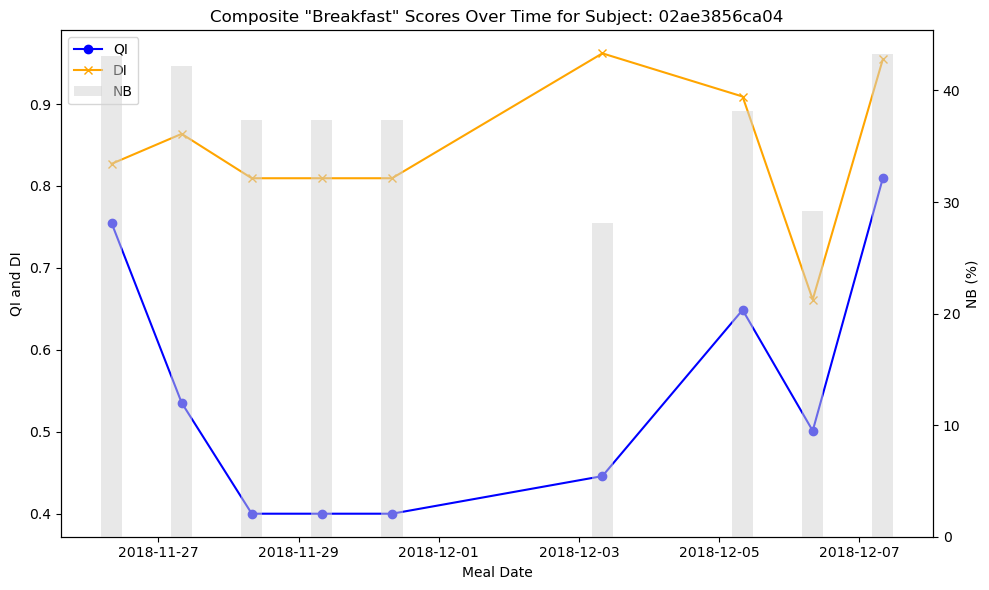

,subject_key,date,total_energy,QI,DI,NB,breakfast_time
0,02ae3856ca04,2018-11-26,481.20,0.754881,0.826979,43.074195,2018-11-26 08:00:00
1,02ae3856ca04,2018-11-27,306.20,0.535263,0.863543,42.200770,2018-11-27 08:00:00
2,02ae3856ca04,2018-11-28,266.20,0.399847,0.809386,37.349043,2018-11-28 08:00:00
3,02ae3856ca04,2018-11-29,266.20,0.399847,0.809386,37.349043,2018-11-29 08:00:00
4,02ae3856ca04,2018-11-30,266.20,0.399847,0.809386,37.349043,2018-11-30 08:00:00
5,02ae3856ca04,2018-12-03,497.80,0.445711,0.961856,28.151130,2018-12-03 08:00:00
6,02ae3856ca04,2018-12-05,441.90,0.648615,0.909151,38.181800,2018-12-05 08:00:00
7,02ae3856ca04,2018-12-06,469.35,0.501058,0.661293,29.173036,2018-12-06 08:00:00
8,02ae3856ca04,2018-12-07,260.55,0.809377,0.954612,43.229820,2018-12-07 08:00:00


In [14]:
subject_id = '02ae3856ca04'
subject_breakfast = composite_breakfast[composite_breakfast['subject_key'] == subject_id]

plot_meal(composite_breakfast[composite_breakfast['subject_key'] == subject_id],
                      subject_id,
                      meal_name='breakfast',
                      time_column='breakfast_time')
subject_breakfast

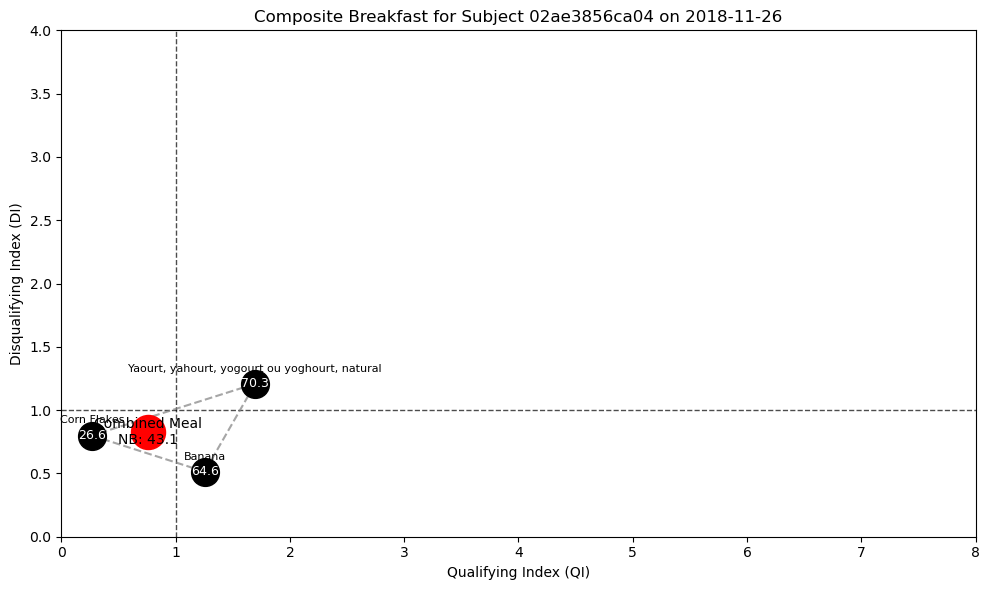

In [15]:
subject_id = '02ae3856ca04'
target_date = pd.to_datetime('2018-11-26').date()
meal_name = 'breakfast'

plot_meal_composite(df_food_clean_scaled, subject_id, target_date, meal_name)

## Lunch analysis

In [16]:
df_lunch = df_food_clean_scaled[df_food_clean_scaled['meal'] == 'lunch']

In [17]:
composite_lunch = df_lunch.groupby(['subject_key', 'date']).apply(
    lambda g: pd.Series({
        'total_energy': g['energy_kcal_eaten'].sum(),
        'QI': weighted_mean(g['QI'], g['energy_kcal_eaten']),
        'DI': weighted_mean(g['DI'], g['energy_kcal_eaten']),
        'NB': weighted_mean(g['NB'], g['energy_kcal_eaten'])
    })
).reset_index()

C:\Users\Sophie\AppData\Local\Temp\ipykernel_11136\2398471281.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  composite_lunch = df_lunch.groupby(['subject_key', 'date']).apply(


In [18]:
composite_lunch['lunch_time'] = pd.to_datetime(composite_lunch['date'].astype(str)) + pd.Timedelta(hours=12)
composite_lunch = composite_lunch[composite_lunch['total_energy'] > 100]


## Snack analysis

In [19]:
df_snack = df_food_clean_scaled[df_food_clean_scaled['meal'] == 'snack']

In [20]:
composite_snack = df_snack.groupby(['subject_key', 'date']).apply(
    lambda g: pd.Series({
        'total_energy': g['energy_kcal_eaten'].sum(),
        'QI': weighted_mean(g['QI'], g['energy_kcal_eaten']),
        'DI': weighted_mean(g['DI'], g['energy_kcal_eaten']),
        'NB': weighted_mean(g['NB'], g['energy_kcal_eaten'])
    })
).reset_index()

C:\Users\Sophie\AppData\Local\Temp\ipykernel_11136\3219763102.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  composite_snack = df_snack.groupby(['subject_key', 'date']).apply(


In [21]:
composite_snack['snack_time'] = pd.to_datetime(composite_lunch['date'].astype(str)) + pd.Timedelta(hours=16)

## Dinner analysis

In [22]:
df_dinner = df_food_clean_scaled[df_food_clean_scaled['meal'] == 'dinner']

In [23]:
composite_dinner = df_dinner.groupby(['subject_key', 'date']).apply(
    lambda g: pd.Series({
        'total_energy': g['energy_kcal_eaten'].sum(),
        'QI': weighted_mean(g['QI'], g['energy_kcal_eaten']),
        'DI': weighted_mean(g['DI'], g['energy_kcal_eaten']),
        'NB': weighted_mean(g['NB'], g['energy_kcal_eaten'])
    })
).reset_index()

C:\Users\Sophie\AppData\Local\Temp\ipykernel_11136\25948918.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  composite_dinner = df_dinner.groupby(['subject_key', 'date']).apply(


In [24]:
composite_dinner['dinner_time'] = pd.to_datetime(composite_dinner['date'].astype(str)) + pd.Timedelta(hours=18)

# Meals analysis for a whole day

In [25]:

save_directory = "composite_meals_graphs"


Plotting breakfast for subject 02ae3856ca04 and saving to composite_meals_graphs\composite_breakfast_subject_02ae3856ca04.png.


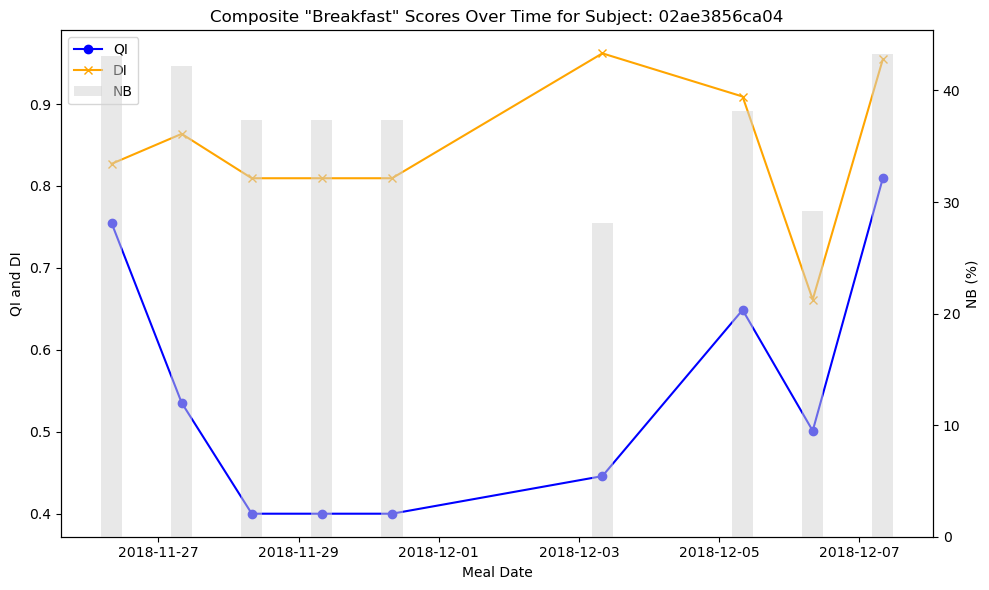

Plotting lunch for subject 02ae3856ca04 and saving to composite_meals_graphs\composite_lunch_subject_02ae3856ca04.png.


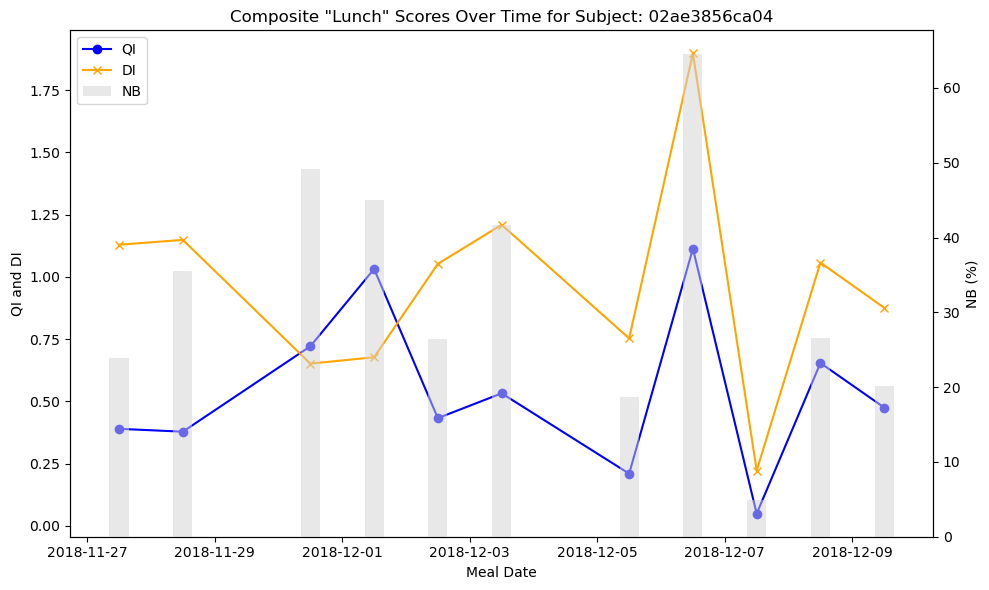

Plotting snack for subject 02ae3856ca04 and saving to composite_meals_graphs\composite_snack_subject_02ae3856ca04.png.


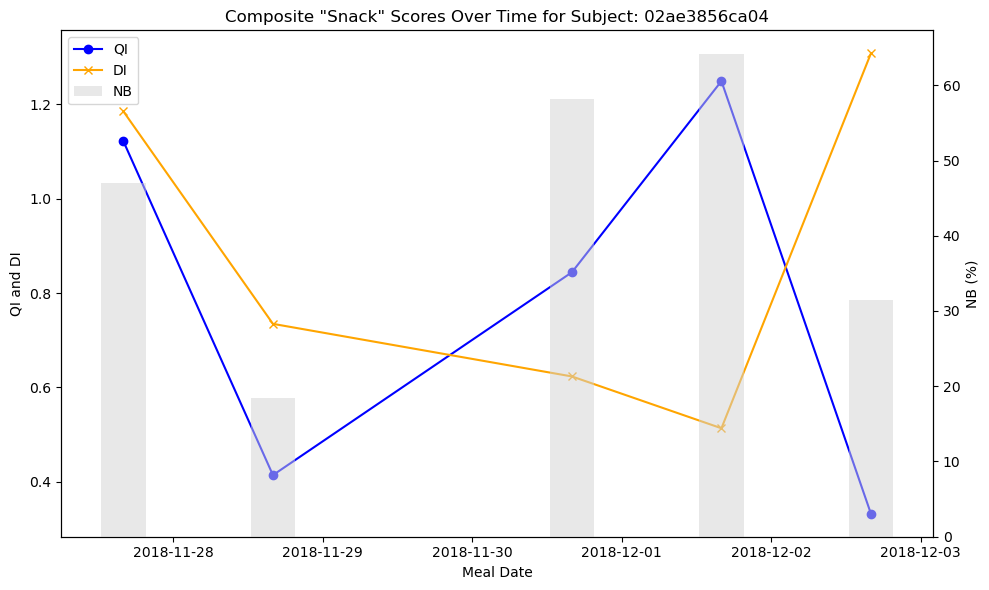

Plotting dinner for subject 02ae3856ca04 and saving to composite_meals_graphs\composite_dinner_subject_02ae3856ca04.png.


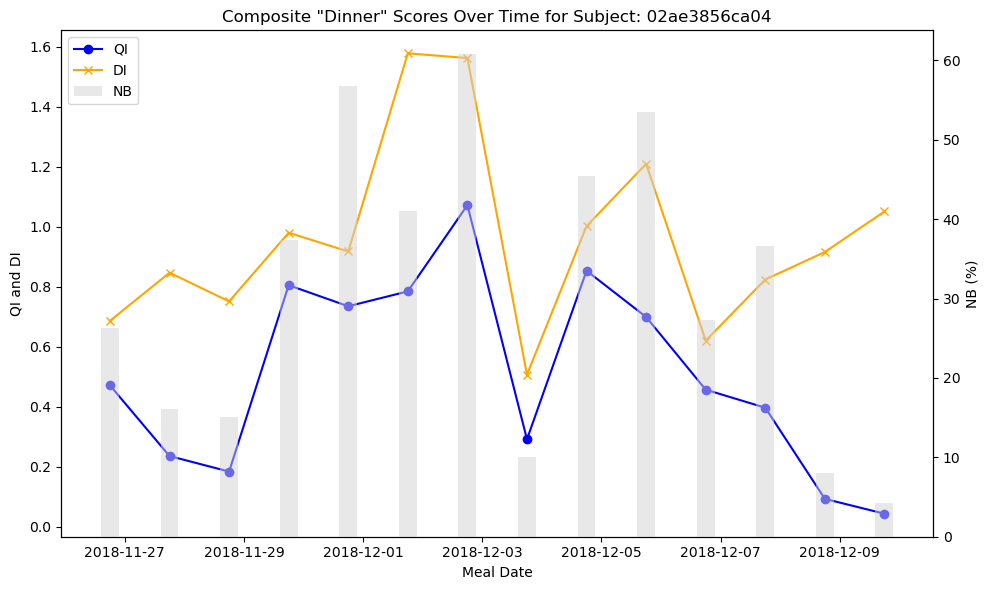

In [26]:
meal_dataframes = {
    'breakfast': composite_breakfast,
    'lunch': composite_lunch,
    'snack': composite_snack,
    'dinner': composite_dinner
}

# And a corresponding mapping for the standardized time columns:
meal_time_columns = {
    'breakfast': 'breakfast_time',
    'lunch': 'lunch_time',
    'snack': 'snack_time',
    'dinner': 'dinner_time'
}

subject_id = '02ae3856ca04'

for meal, df_meal in meal_dataframes.items():
    # Filter for the subject of interest:
    subject_df = df_meal[df_meal['subject_key'] == subject_id]
    if subject_df.empty:
        print(f"No {meal} data for subject {subject_id}.")
    else:
        save_filename = f"composite_{meal}_subject_{subject_id}.png"
        save_path = os.path.join(save_directory, save_filename)
        print(f"Plotting {meal} for subject {subject_id} and saving to {save_path}.")
        plot_meal(subject_df, subject_id, meal_name=meal, time_column=meal_time_columns[meal], save_path=save_path)

Plotting breakfast for subject 02ae3856ca04 on 2018-12-06...


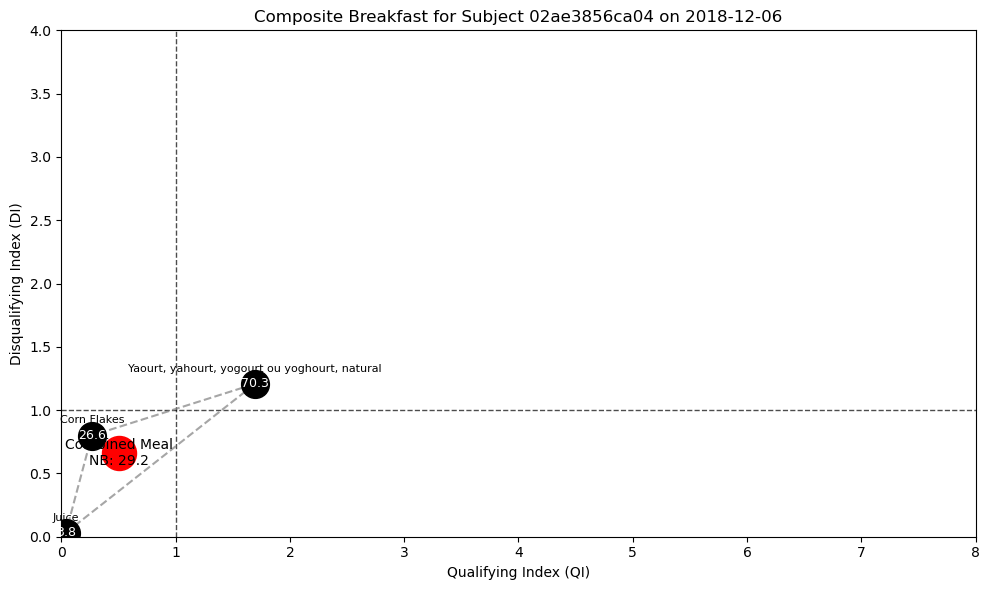

Plotting lunch for subject 02ae3856ca04 on 2018-12-06...


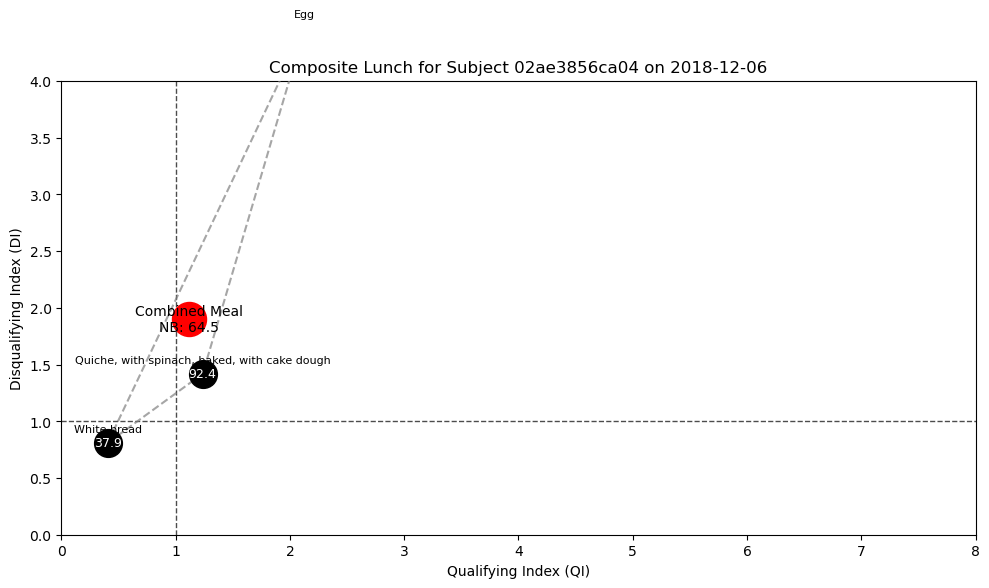

Plotting snack for subject 02ae3856ca04 on 2018-12-06...
No data for subject 02ae3856ca04 on 2018-12-06 for snack.
Plotting dinner for subject 02ae3856ca04 on 2018-12-06...


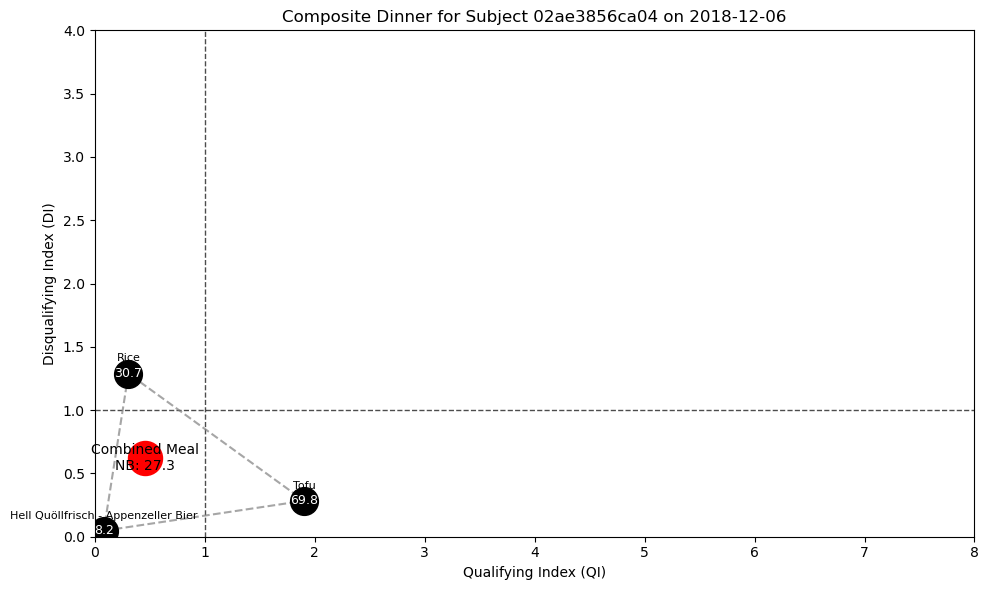

In [27]:
meal_types = ['breakfast', 'lunch', 'snack', 'dinner']

subject_id = '02ae3856ca04'
target_date = pd.to_datetime('2018-12-06').date()

for meal in meal_types:
    print(f"Plotting {meal} for subject {subject_id} on {target_date}...")
    save_filename = f"composite_{meal}_subject_{subject_id}_{target_date}.png"
    save_path = os.path.join(save_directory, save_filename)
    plot_meal_composite(df_food_clean_scaled, subject_id, target_date, meal, save_path=save_path)

### Daywise

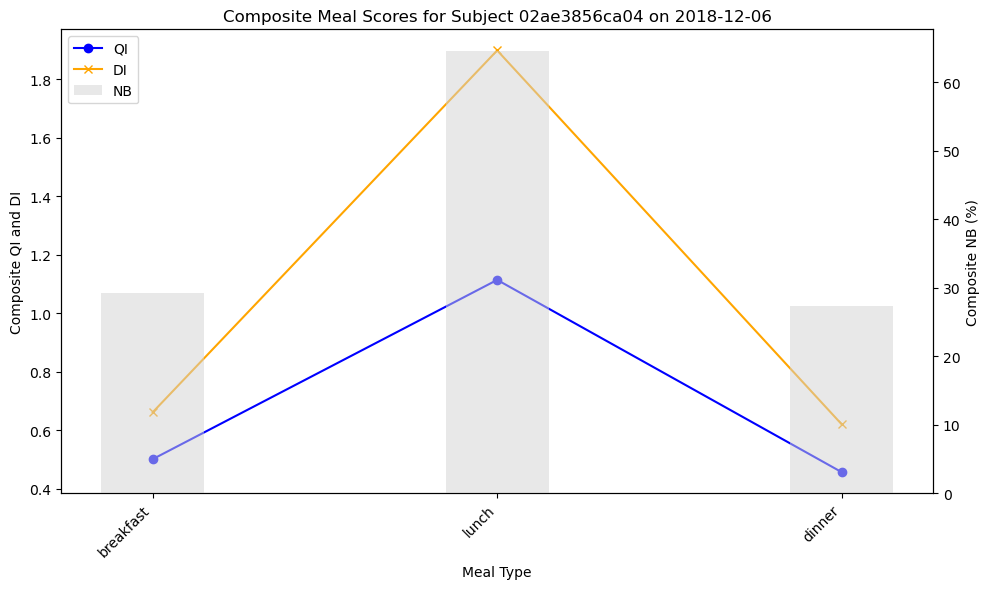

,subject_key,date,meal,total_energy,QI,DI,NB
28,02ae3856ca04,2018-12-06,breakfast,469.350,0.501058,0.661293,29.173036
30,02ae3856ca04,2018-12-06,lunch,329.900,1.113636,1.897834,64.473979
29,02ae3856ca04,2018-12-06,dinner,319.152,0.456654,0.620192,27.305697


In [28]:
subject_id = '02ae3856ca04'
target_date = pd.to_datetime('2018-12-06').date()

df_day = composite_meals[(composite_meals['subject_key'] == subject_id) & 
                         (pd.to_datetime(composite_meals['date']).dt.date == target_date)]

save_filename = f"composite_meals_{subject_id}_{target_date}.png"
save_path = os.path.join(save_directory, save_filename)
plot_day_meals(df_day, subject_id, target_date, save_path=save_path)

# Analysis over days of the week

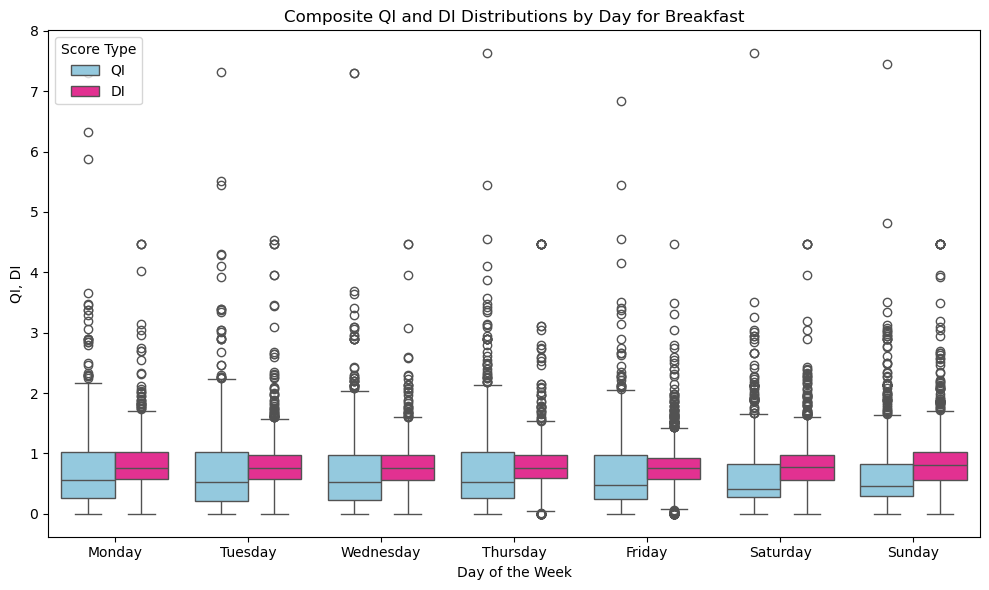

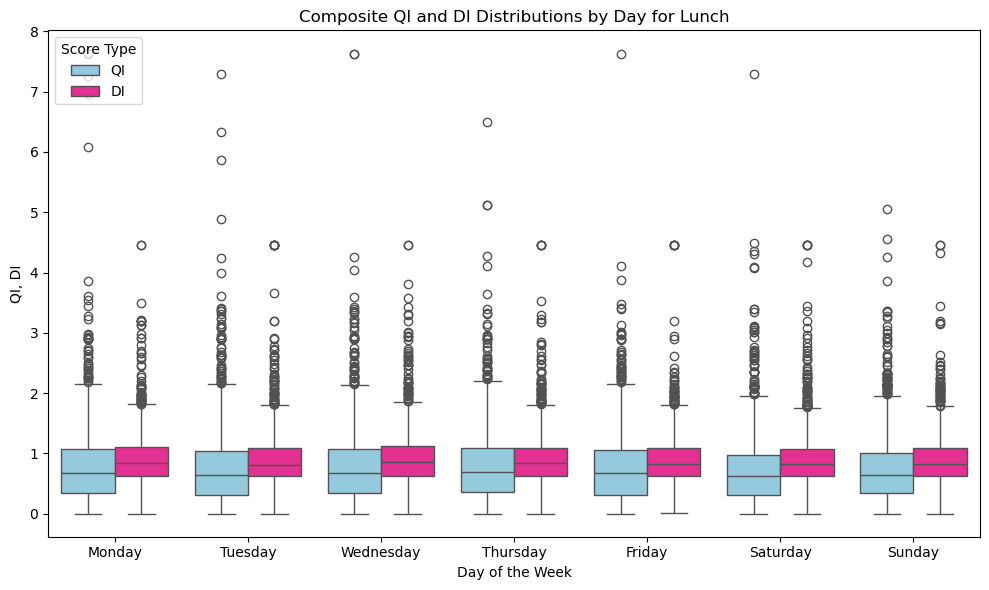

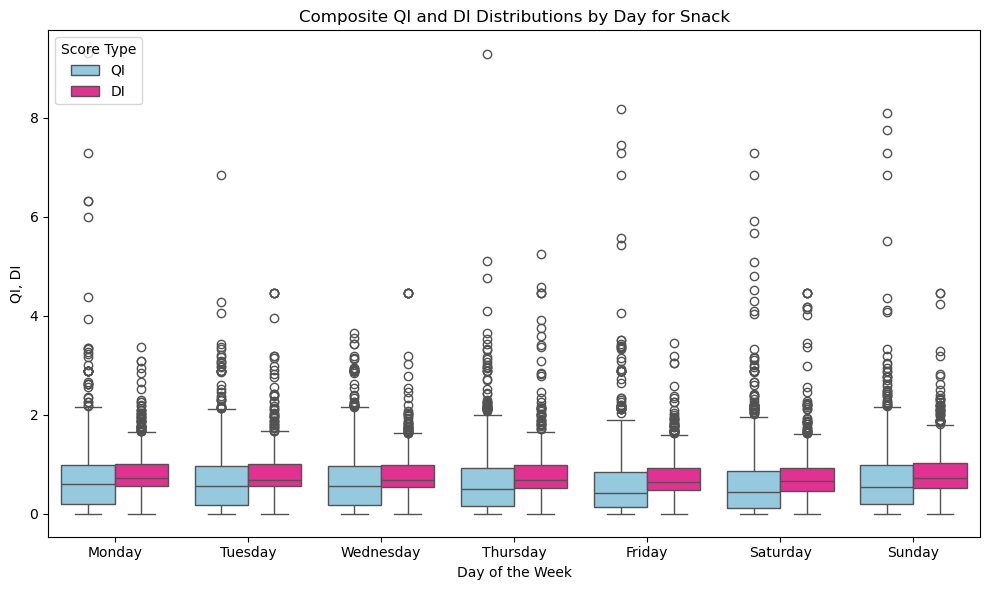

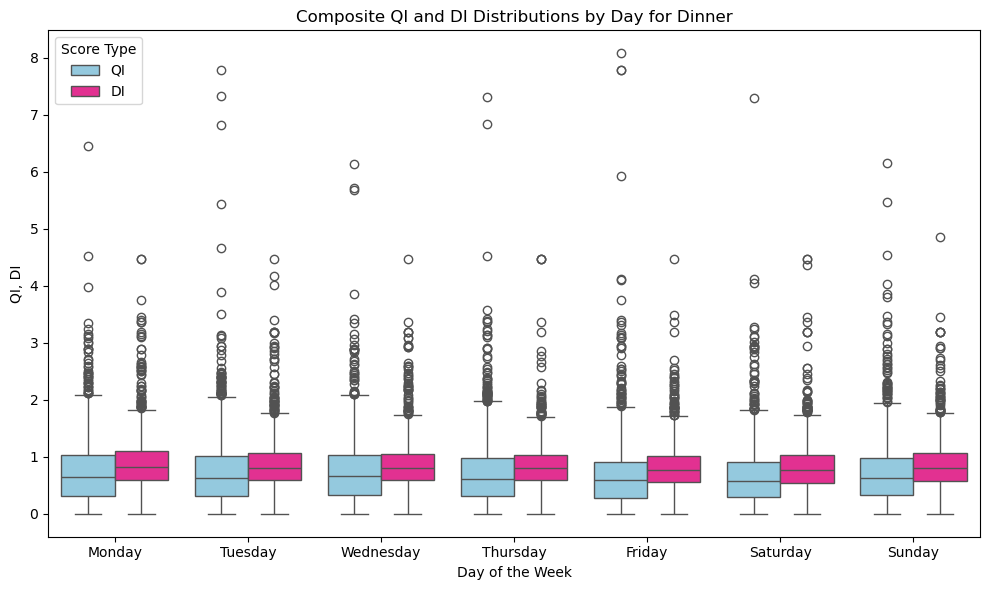

In [29]:
for meal in meal_types:
    save_path = os.path.join(save_directory, f"Daily_QI_DI_Boxplot_{meal}.png")
    plot_daily_qi_di_boxplots(composite_meals, meal_type=meal, save_path=save_path)

In [30]:
composite_meals_days = add_type_of_day(composite_meals)

In [31]:
composite_meals_days

,subject_key,date,meal,total_energy,QI,DI,NB,day_of_week,type_of_day
0,02ae3856ca04,2018-11-26,breakfast,481.200,0.754881,0.826979,43.074195,Monday,weekday
1,02ae3856ca04,2018-11-26,dinner,1113.400,0.471009,0.686300,26.292519,Monday,weekday
2,02ae3856ca04,2018-11-26,snack,712.400,1.121084,1.184370,47.073860,Monday,weekday
3,02ae3856ca04,2018-11-27,breakfast,306.200,0.535263,0.863543,42.200770,Tuesday,weekday
4,02ae3856ca04,2018-11-27,dinner,1642.700,0.235269,0.846779,16.123350,Tuesday,weekday
...,...,...,...,...,...,...,...,...,...
37296,zznk4w,2022-09-23,dinner,1067.125,0.684486,0.865495,49.553098,Friday,weekday
37297,zznk4w,2022-09-24,breakfast,619.850,0.550543,0.869205,24.891677,Saturday,weekend
37298,zznk4w,2022-09-24,dinner,720.050,0.233153,0.985080,20.532378,Saturday,weekend
37299,zznk4w,2022-09-24,lunch,710.250,0.225787,0.741355,18.920001,Saturday,weekend


In [32]:
days_of_week_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df = composite_meals_days.copy()
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_of_week_order, ordered=True)

# filter out low‐energy meals 
df = df[df['total_energy'] > 0]

grouped = df.groupby(['meal','day_of_week'])[['QI','DI']].agg(['mean','median'])

grouped.columns = ['_'.join(col) for col in grouped.columns]
grouped = grouped.reset_index()

display(grouped.sort_values(['meal','day_of_week']))

C:\Users\Sophie\AppData\Local\Temp\ipykernel_11136\3971574589.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['meal','day_of_week'])[['QI','DI']].agg(['mean','median'])


,meal,day_of_week,QI_mean,QI_median,DI_mean,DI_median
0,breakfast,Monday,0.708444,0.555663,0.818002,0.749690
1,breakfast,Tuesday,0.709674,0.519573,0.823632,0.749690
2,breakfast,Wednesday,0.684461,0.526858,0.800410,0.749690
3,breakfast,Thursday,0.706811,0.521356,0.831737,0.753281
4,breakfast,Friday,0.659337,0.468804,0.799087,0.750664
5,breakfast,Saturday,0.596086,0.413769,0.801735,0.781952
6,breakfast,Sunday,0.616659,0.457823,0.830574,0.809386
7,dinner,Monday,0.741453,0.643141,0.889216,0.820716
8,dinner,Tuesday,0.744467,0.630162,0.859459,0.797356
9,dinner,Wednesday,0.739742,0.654323,0.853128,0.794297


In [33]:
qi_mean_pivot = grouped.pivot(index='day_of_week', columns='meal', values='QI_mean')
di_mean_pivot   = grouped.pivot(index='day_of_week', columns='meal', values='DI_mean')

qi_mean_pivot

meal,breakfast,dinner,lunch,snack
day_of_week,,,,
Monday,0.708444,0.741453,0.789994,0.743385
Tuesday,0.709674,0.744467,0.768268,0.686865
Wednesday,0.684461,0.739742,0.793040,0.691588
Thursday,0.706811,0.713400,0.796123,0.671853
Friday,0.659337,0.680769,0.762516,0.632613
Saturday,0.596086,0.656977,0.718527,0.638326
Sunday,0.616659,0.725338,0.739185,0.722872


In [34]:
di_mean_pivot

meal,breakfast,dinner,lunch,snack
day_of_week,,,,
Monday,0.818002,0.889216,0.919509,0.794381
Tuesday,0.823632,0.859459,0.907261,0.804451
Wednesday,0.800410,0.853128,0.926795,0.782341
Thursday,0.831737,0.826815,0.916490,0.776613
Friday,0.799087,0.793702,0.891975,0.711803
Saturday,0.801735,0.808924,0.893643,0.732469
Sunday,0.830574,0.850128,0.890242,0.805317


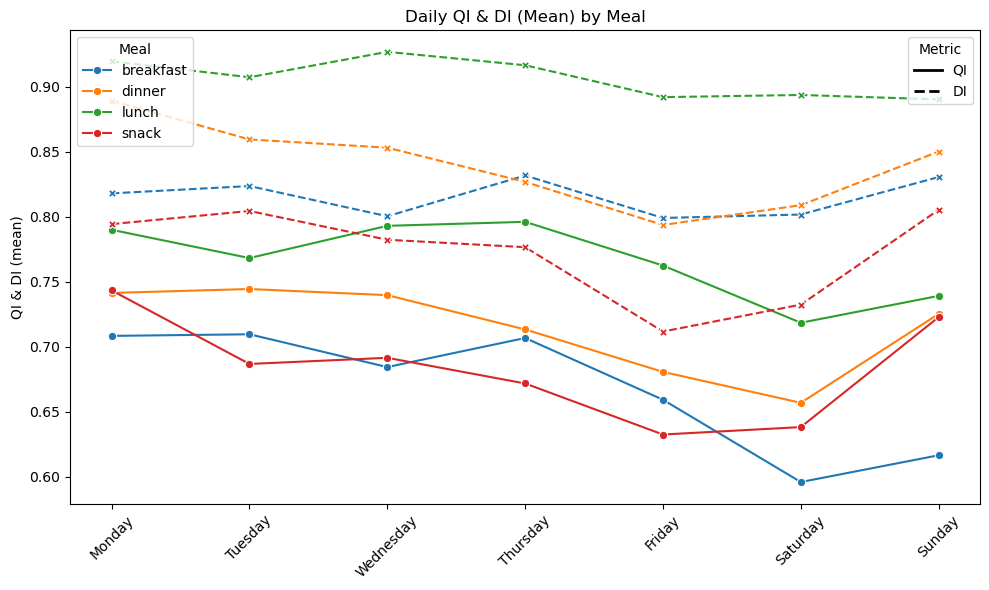

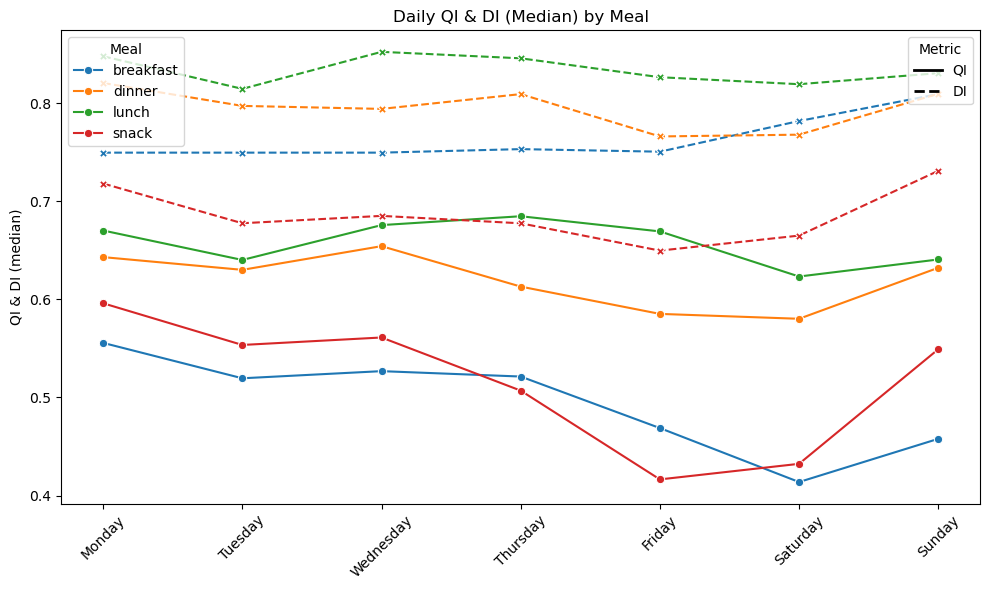

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Daily QI & DI (Median) by Meal'}, ylabel='QI & DI (median)'>)

In [35]:
save_path = os.path.join(save_directory, f"Daily_QI_DI_(mean)_by_meal.png")
plot_qi_di_by_meal(grouped, agg='mean', save_path=save_path)

save_path = os.path.join(save_directory, f"Daily_QI_DI_(median)_by_meal.png")
plot_qi_di_by_meal(grouped, agg='median', save_path=save_path)

In [36]:
test_results = test_weekday_vs_weekend(composite_meals_days)
test_results['significatif'] = test_results['p_value'].apply(star)
test_results

,meal,metric,weekday_n,weekend_n,U_stat,p_value,significatif
0,breakfast,QI,4896,2719,6959368.5,0.000965,***
1,breakfast,DI,4896,2719,6611176.0,0.624776,ns
2,dinner,QI,7013,2771,9949337.0,0.064376,ns
3,dinner,DI,7013,2771,9872774.0,0.214477,ns
4,snack,QI,4007,1756,3495145.0,0.692375,ns
5,snack,DI,4007,1756,3575009.0,0.328023,ns
6,lunch,QI,6607,3052,10437988.5,0.005240,**
7,lunch,DI,6607,3052,10385454.0,0.017333,*


In [37]:
pivot = test_results.pivot(index='meal', columns='metric', values=['p_value','significatif'])
pivot

p_value           significatif     
metric           DI        QI           DI   QI
meal                                           
breakfast  0.624776  0.000965           ns  ***
dinner     0.214477  0.064376           ns   ns
lunch      0.017333   0.00524            *   **
snack      0.328023  0.692375           ns   ns

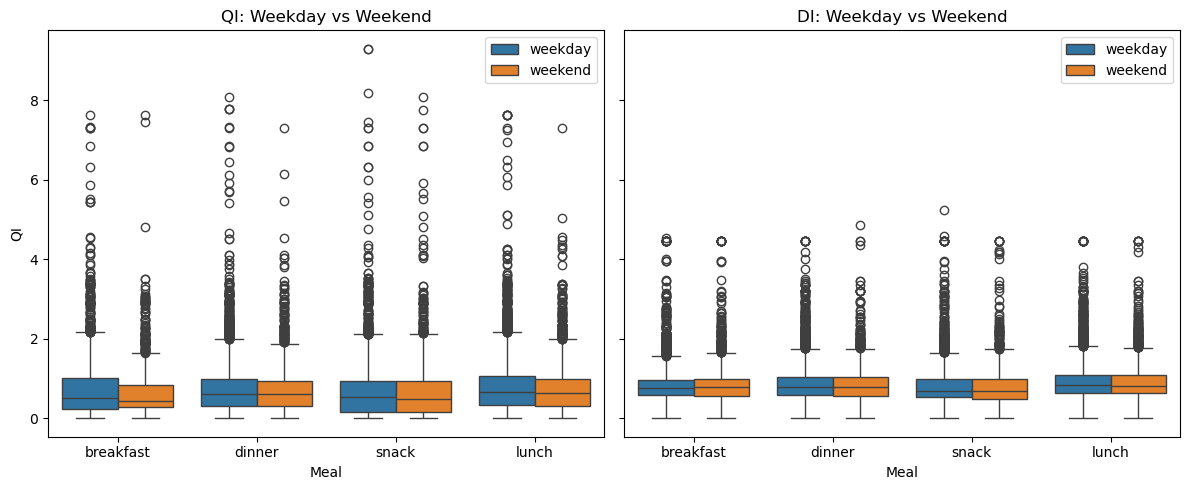

In [38]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharey=True)
sns.boxplot(x='meal', y='QI', hue='type_of_day', data=composite_meals_days.query("total_energy> 0"), ax=axes[0])
axes[0].set_title("QI: Weekday vs Weekend")
sns.boxplot(x='meal', y='DI', hue='type_of_day', data=composite_meals_days.query("total_energy> 0"), ax=axes[1])
axes[1].set_title("DI: Weekday vs Weekend")
for ax in axes:
    ax.legend(title="")
    ax.set_xlabel("Meal")

save_path = os.path.join(save_directory, f"QI_DI_weekday_vs_weekend.png")
plt.savefig(save_path)
plt.tight_layout()
plt.show()

Saved to composite_meals_graphs\Monday_QI_DI_by_meal.png


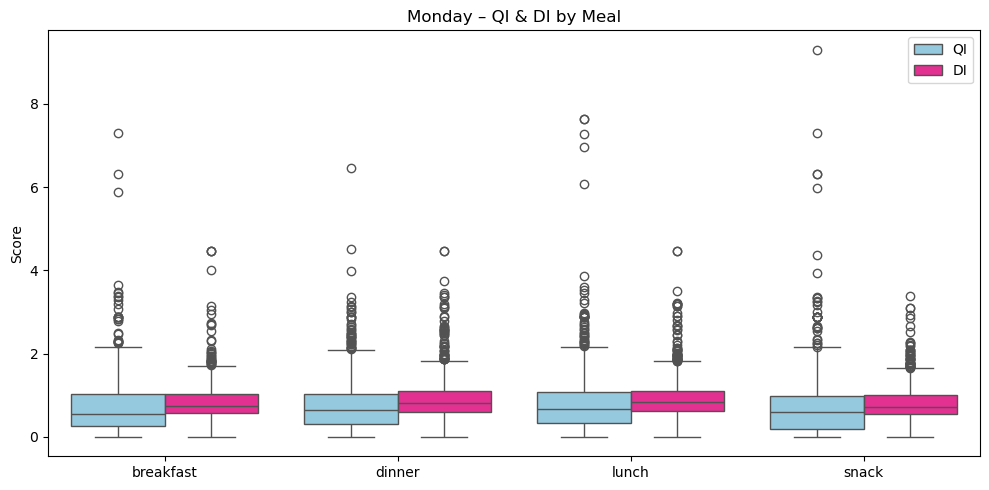

Saved to composite_meals_graphs\Tuesday_QI_DI_by_meal.png


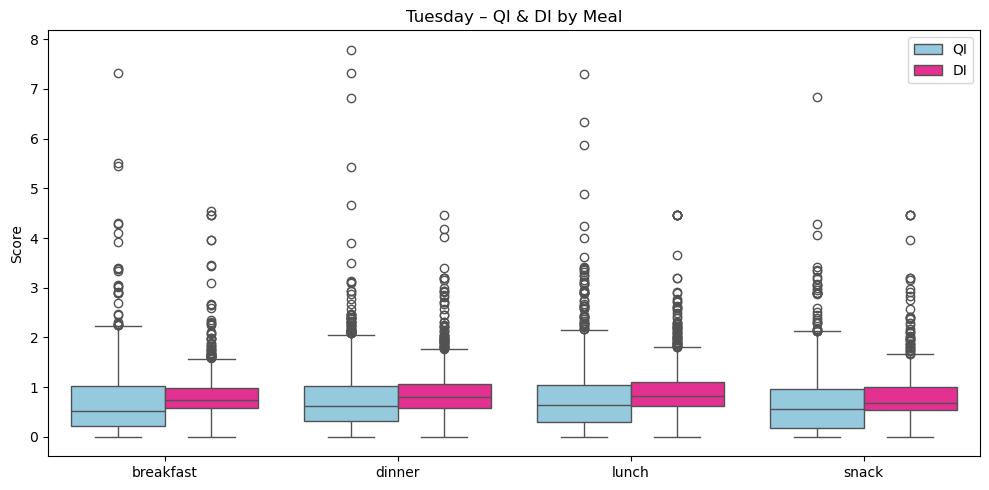

Saved to composite_meals_graphs\Wednesday_QI_DI_by_meal.png


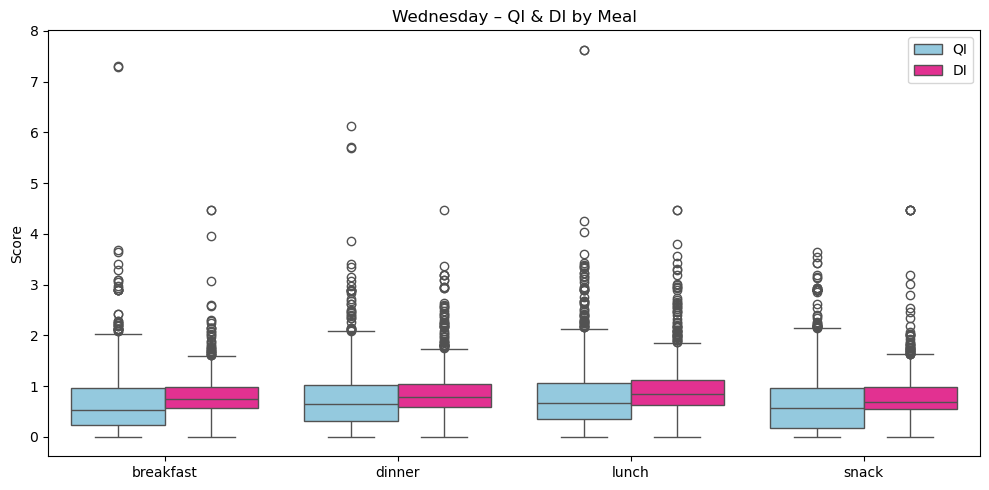

Saved to composite_meals_graphs\Thursday_QI_DI_by_meal.png


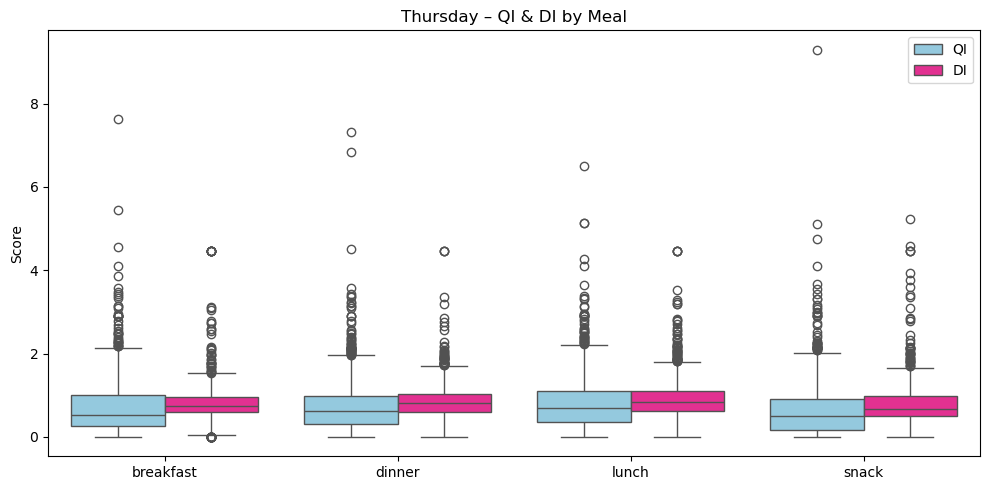

Saved to composite_meals_graphs\Friday_QI_DI_by_meal.png


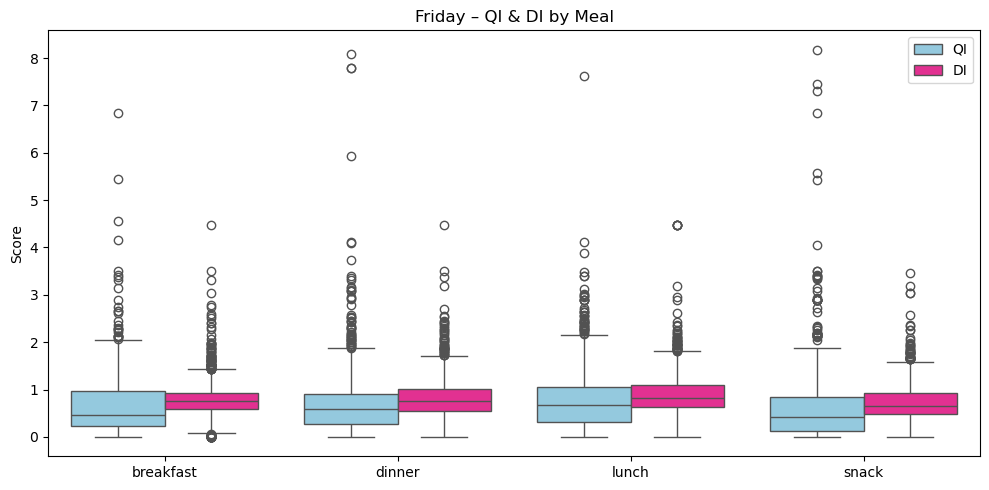

Saved to composite_meals_graphs\Saturday_QI_DI_by_meal.png


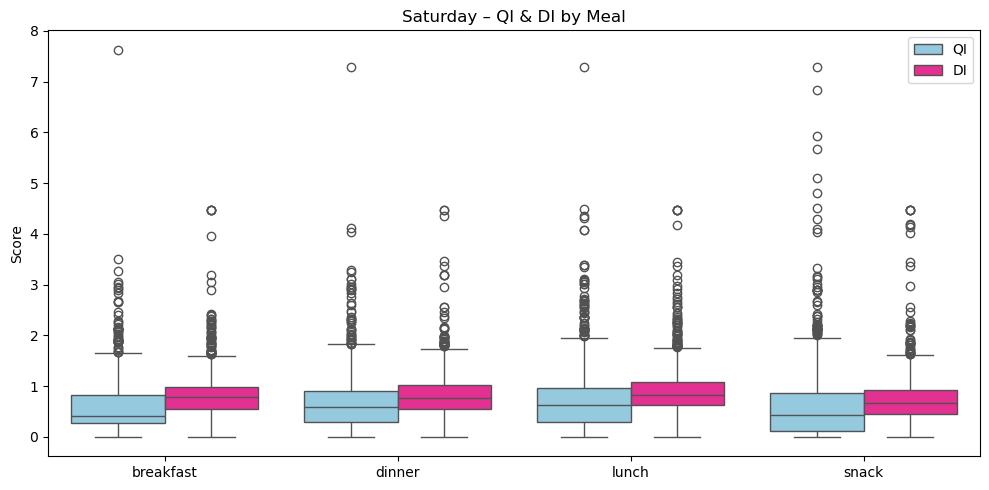

Saved to composite_meals_graphs\Sunday_QI_DI_by_meal.png


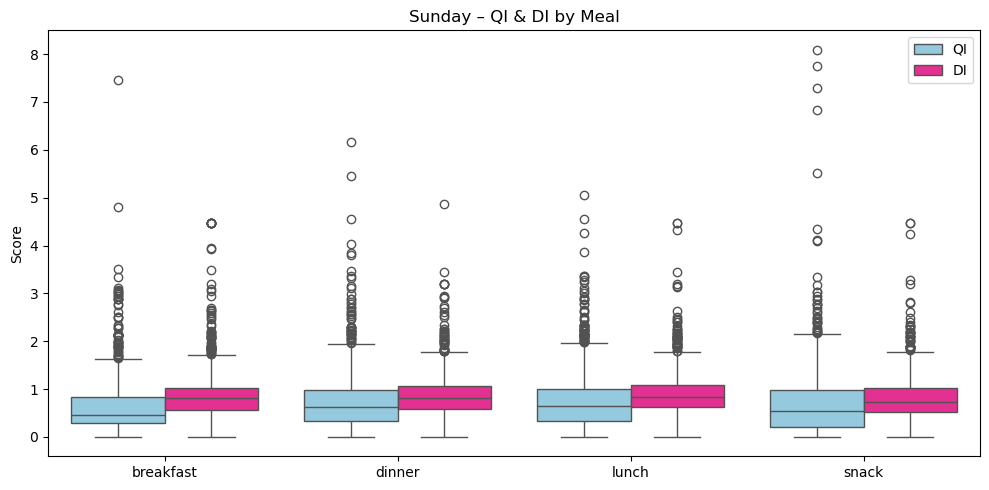

In [39]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for d in days:
    save_path = os.path.join(save_directory, f"{d}_QI_DI_by_meal.png")
    boxplot_qi_di_by_meal_for_day(
      composite_meals_days,
      day_of_week=d,
      save_path=save_path
    )

**Breakfast** : = QI is always higher in weekdays compared to the weekend

**Lunch** : = Same as breakfast, QI is generally higher in weekdays compared to the weekend

**Dinner** : = For dinner, DI is always higher, independently of the day of the week

**Snack** : = As for snack, QI seems higher at the beginning of the week (Monday to Wednesday), and after DI become higher the last part of the week

# Relationship of Nutrient Balance to Qualifyinf Index (QI)

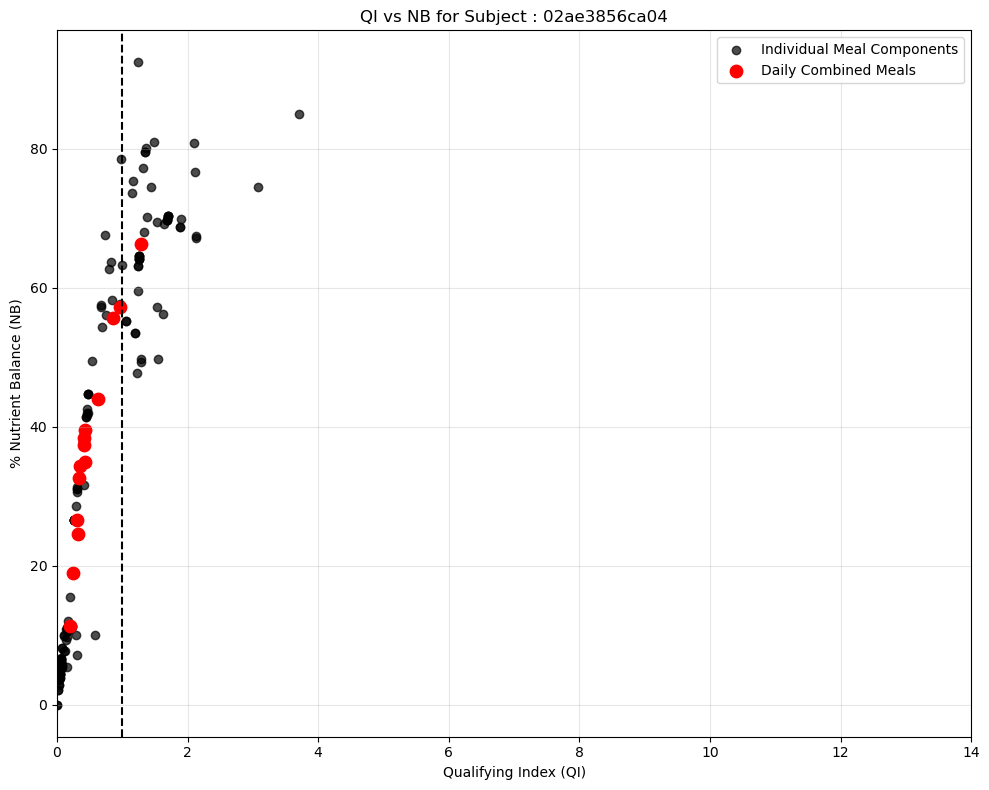

          date        QI         NB
0   2018-11-26  0.307159  26.566322
1   2018-11-27  0.417703  37.349043
2   2018-11-28  0.409416  38.305926
3   2018-11-29  0.621932  43.979794
4   2018-11-30  0.433018  39.528963
5   2018-12-01  0.967685  57.270126
6   2018-12-02  0.854473  55.658939
7   2018-12-03  0.429096  34.965917
8   2018-12-04  1.291617  66.331109
9   2018-12-05  0.247066  18.896361
10  2018-12-06  0.355992  34.281408
11  2018-12-07  0.336467  32.610464
12  2018-12-08  0.195627  11.331508
13  2018-12-09  0.318060  24.568105


In [40]:
subject_id = '02ae3856ca04'
start_date = pd.to_datetime('2018-11-26').date()
end_date = pd.to_datetime('2018-12-09').date()

plot_qi_nb_scatter(subject_id, df_food_clean_scaled, start_date, end_date)

## Nutrient ratio distribution per meal type

In [41]:
nutrient_cols = [i for i in df_food_clean_scaled.columns if i.endswith('_ratio_scaled')]
save_path_distribution = 'composite_meals_graphs/nutrient_distribution_graphs'

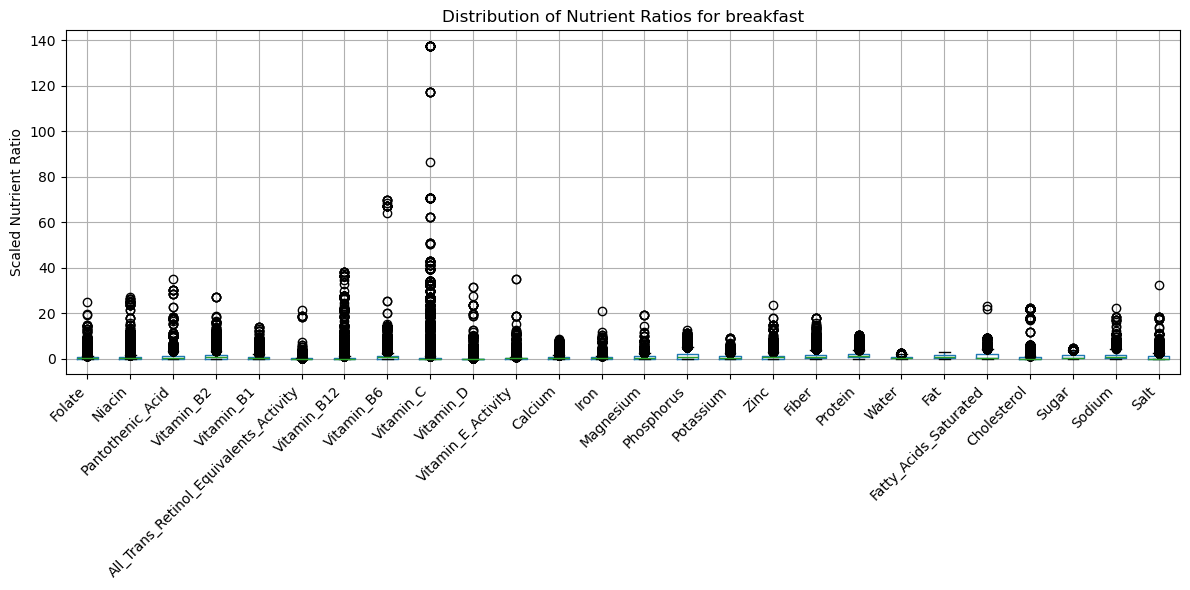

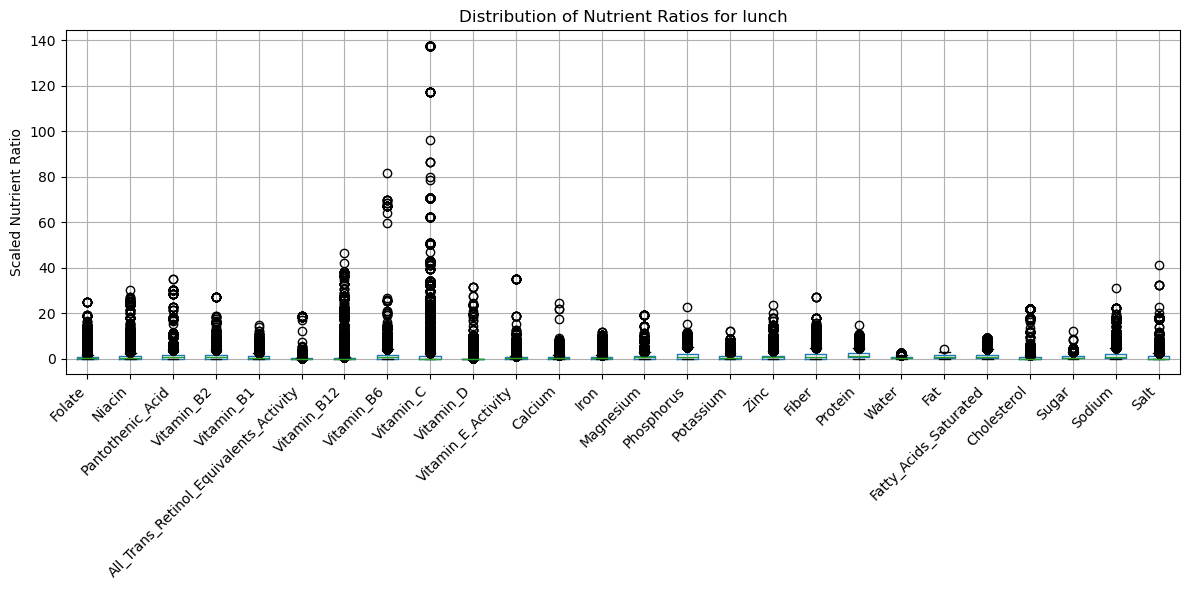

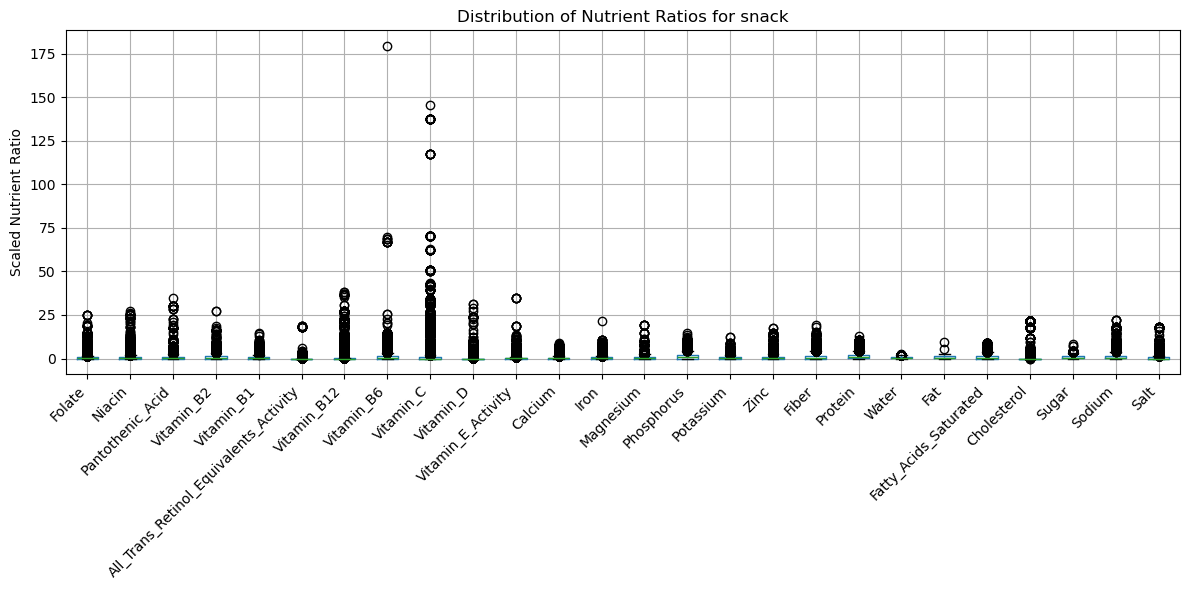

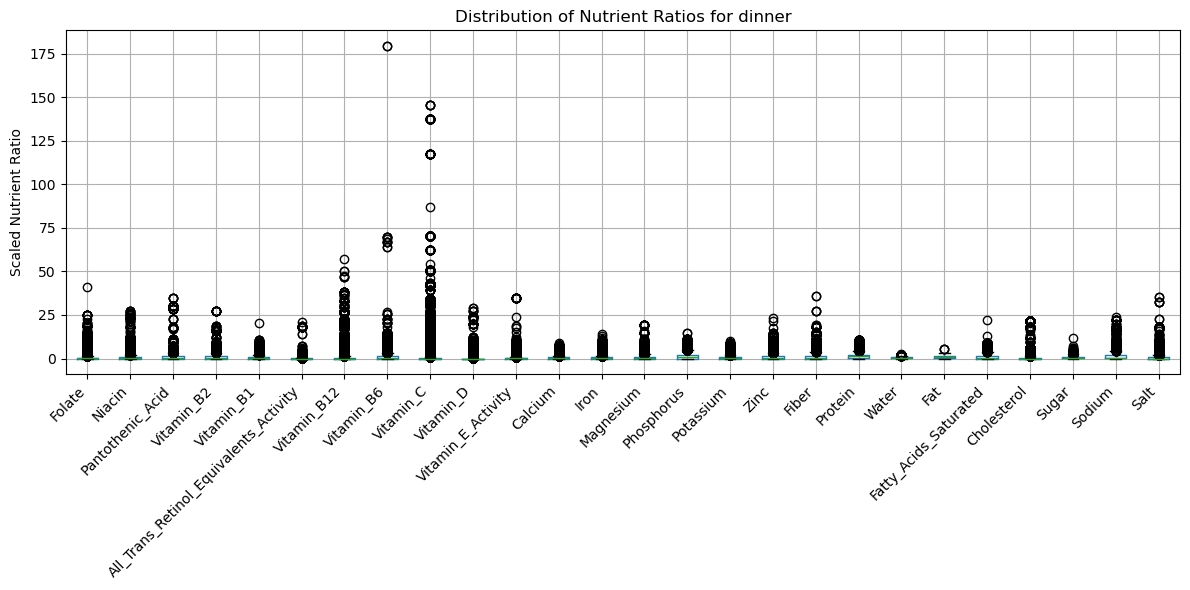

In [42]:
meal_types = ['breakfast', 'lunch', 'snack', 'dinner']

for meal in meal_types:
    subset = df_food_clean_scaled[df_food_clean_scaled['meal'] == meal]
    
    if subset.empty:
        print(f"Warning: no rows found for {meal!r}")
        continue
    
    plt.figure(figsize=(12, 6))
    # draws box for each nutrient col
    subset[nutrient_cols].boxplot()
    
    plt.title(f'Distribution of Nutrient Ratios for {meal}')
    plt.ylabel('Scaled Nutrient Ratio')
    plt.xticks(
        range(1, len(nutrient_cols)+1),
        [c.replace('_eaten_ratio_scaled','').title() 
         for c in nutrient_cols],
        rotation=45, ha='right'
    )
 
    plt.tight_layout()
    filename = f"{save_path_distribution}/nutrient_distribution_for_{meal}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

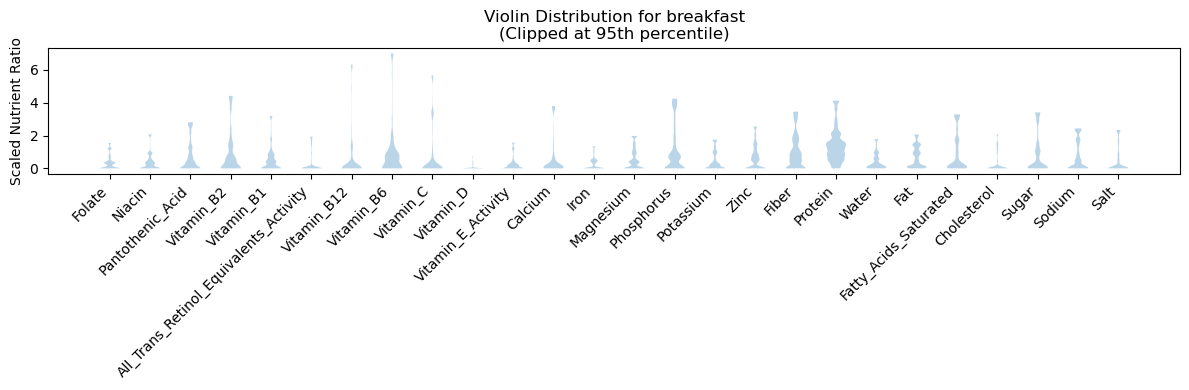

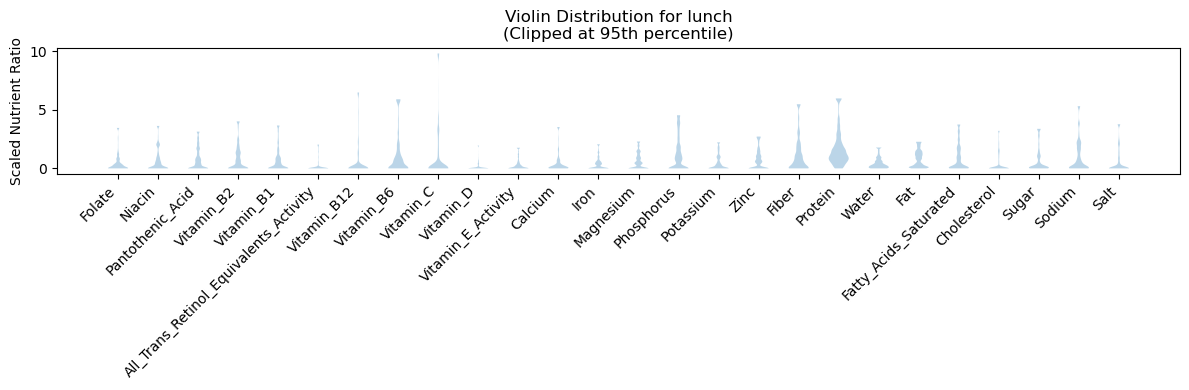

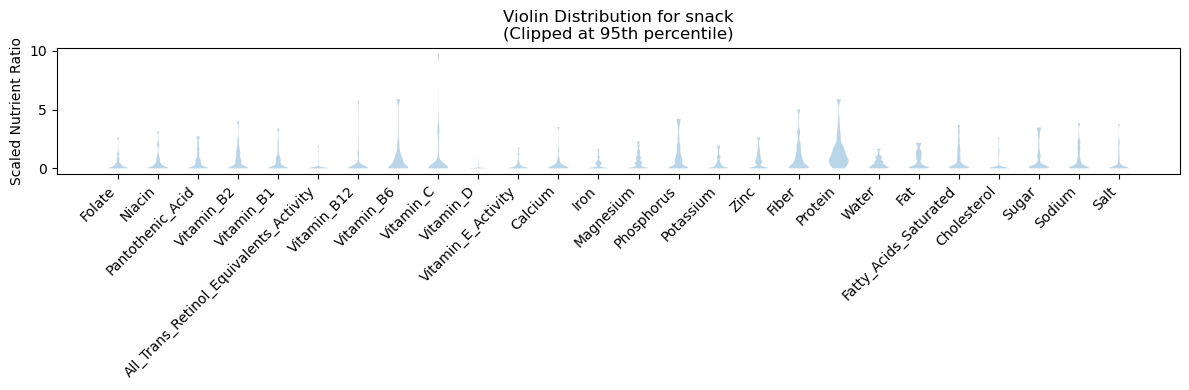

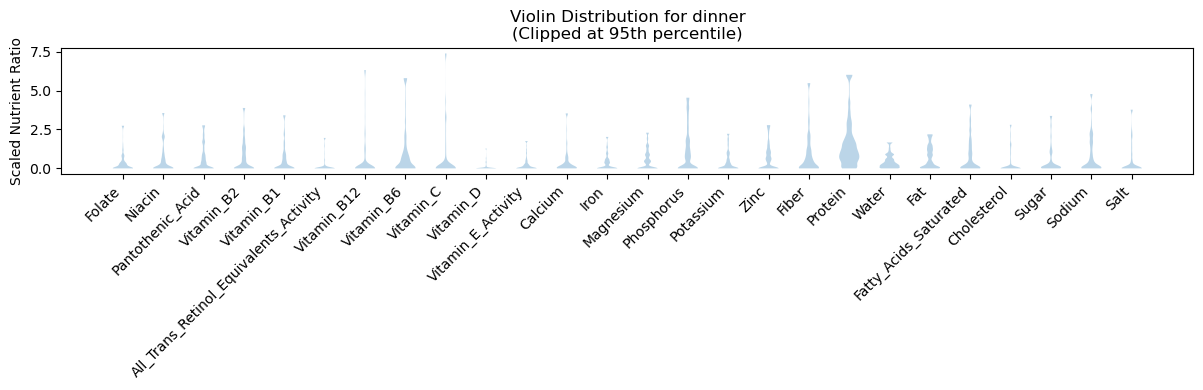

In [43]:
for meal in meal_types:
    subset = df_food_clean_scaled[df_food_clean_scaled['meal']==meal]
    data = []
    # clip each nutrient at its own 95th percentile
    for n in nutrient_cols:
        arr = subset[n].dropna().values
        upper = np.percentile(arr, 95)
        data.append(np.clip(arr, a_min=0, a_max=upper))

    plt.figure(figsize=(12,4))
    plt.violinplot(data, showextrema=False)
    plt.title(f'Violin Distribution for {meal}\n(Clipped at 95th percentile)')
    plt.xticks(np.arange(1, len(nutrient_cols)+1),
               [n.replace('_eaten_ratio_scaled','').title() for n in nutrient_cols],
               rotation=45, ha='right')
    plt.ylabel('Scaled Nutrient Ratio')
    plt.tight_layout()
    filename = f"{save_path_distribution}/violin_distribution_for_{meal}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

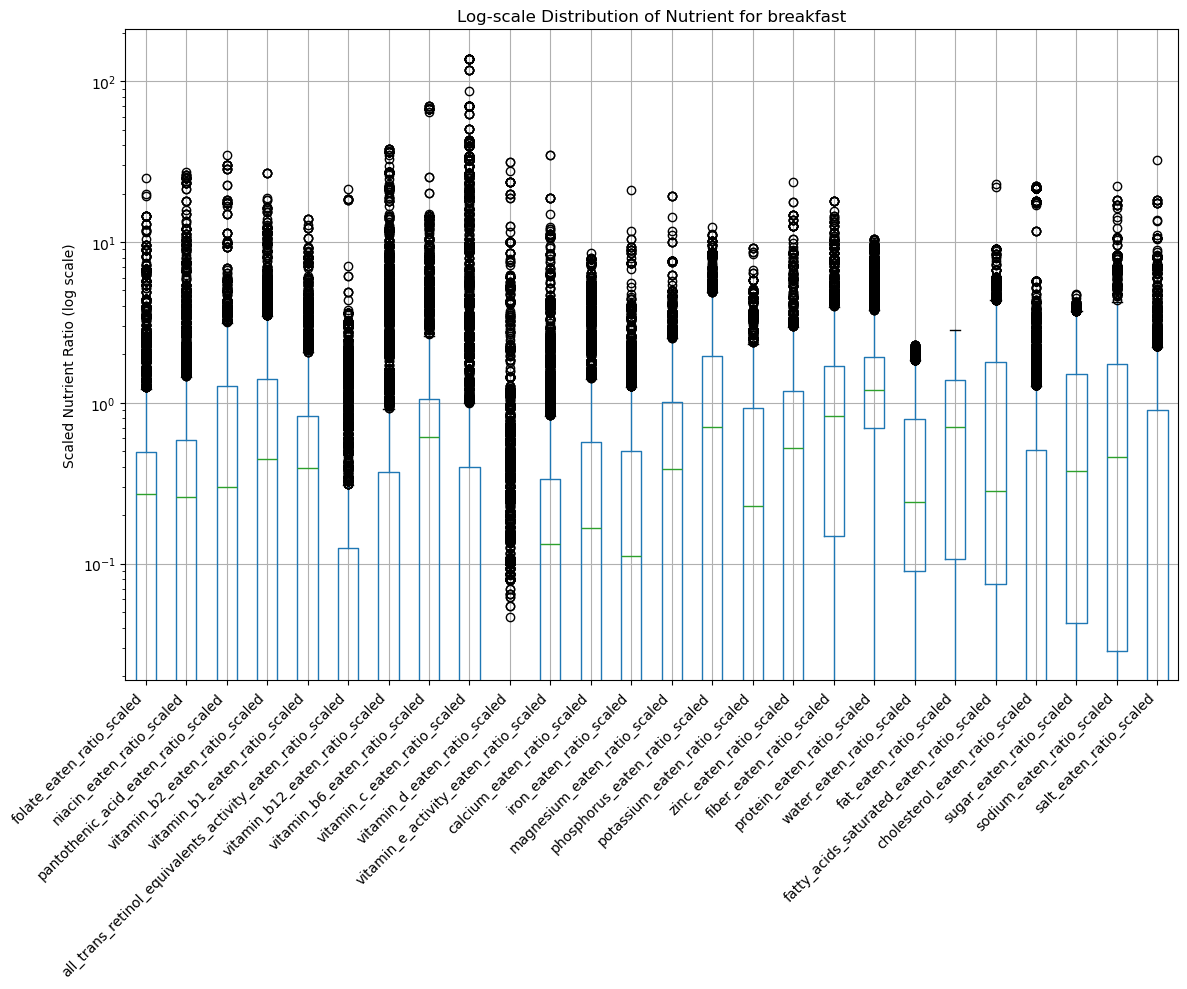

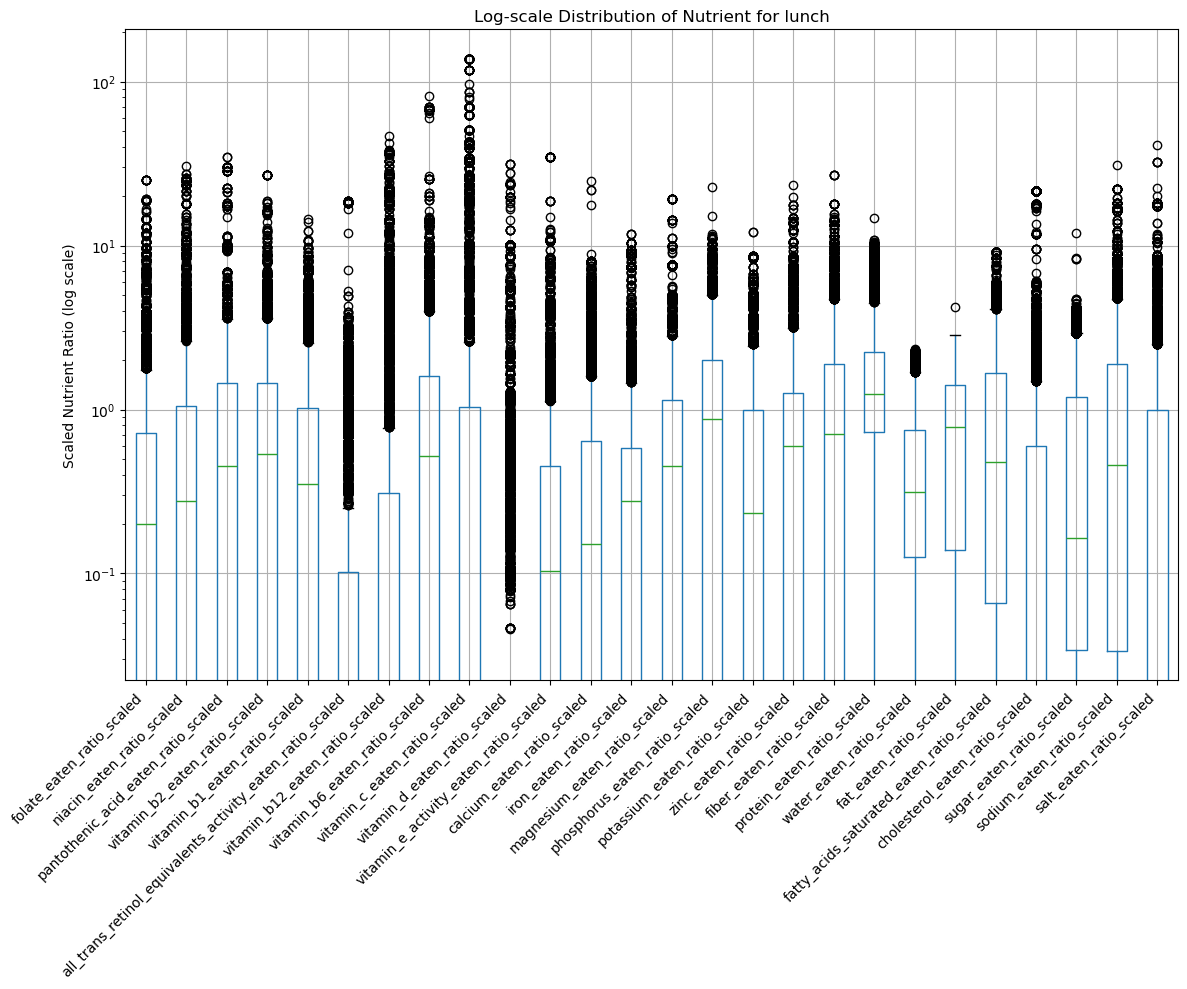

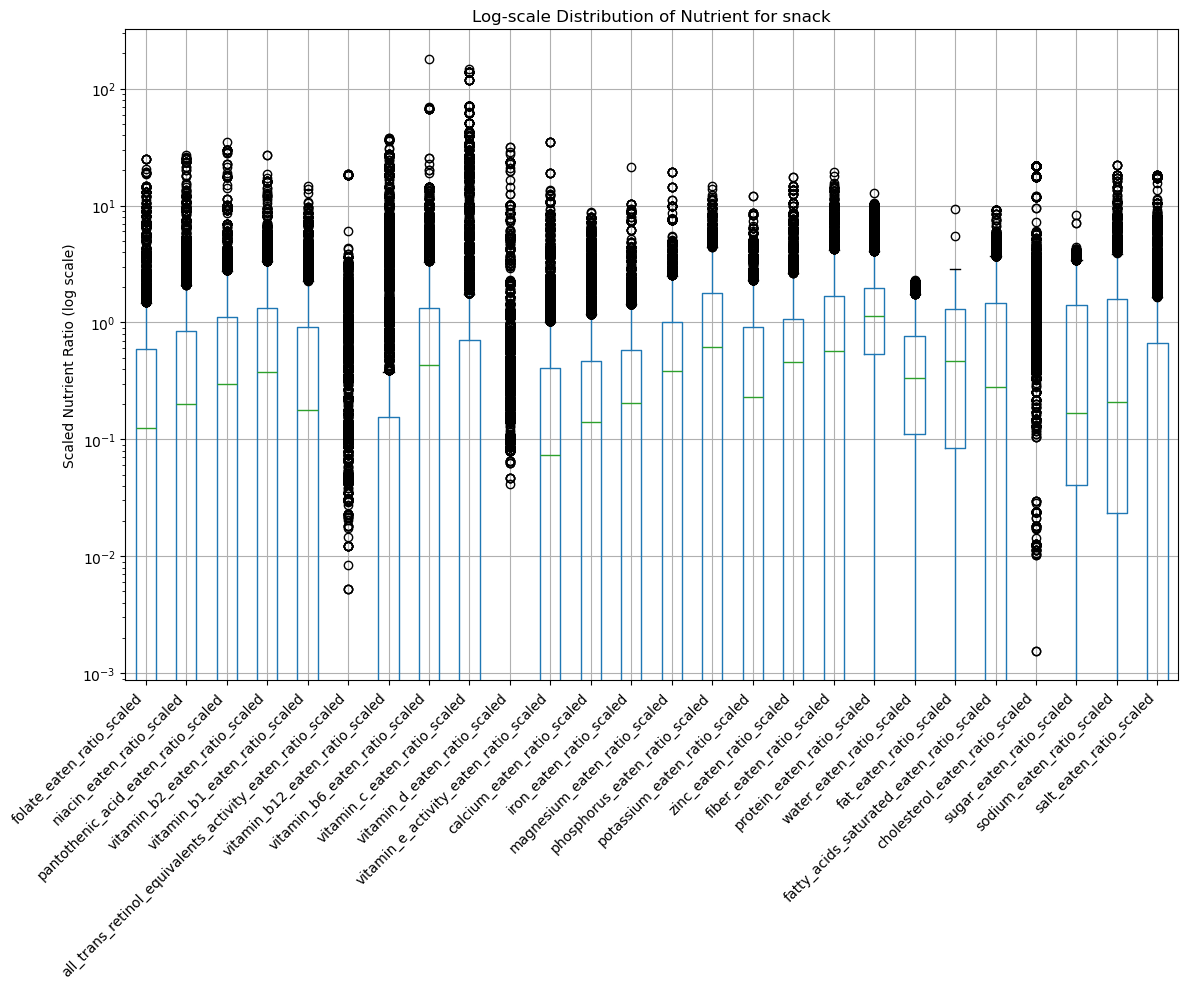

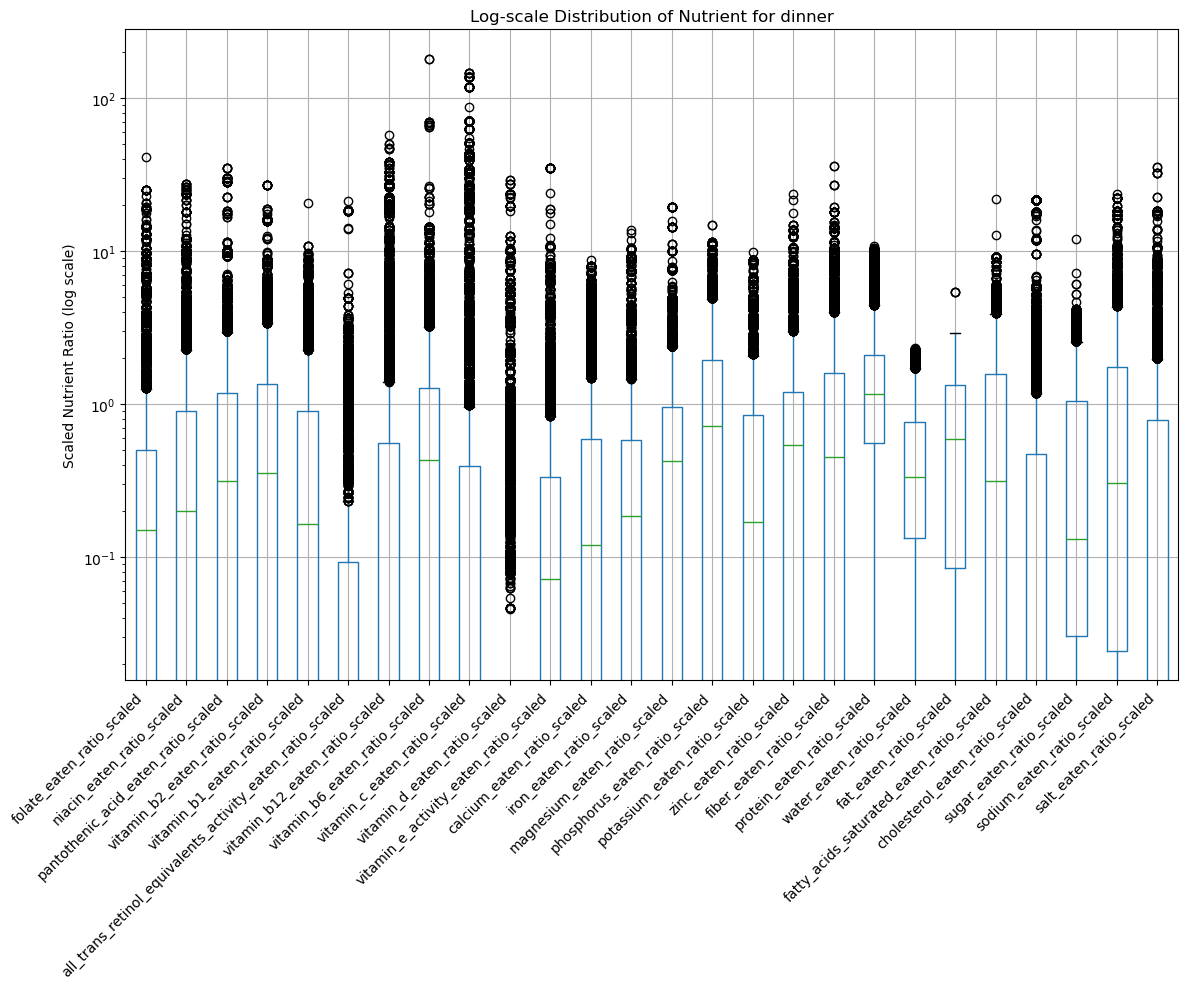

In [48]:
for meal in meal_types:
    subset = df_food_clean_scaled[df_food_clean_scaled['meal']==meal]
    plt.figure(figsize=(12,10))
    bp = subset[nutrient_cols].boxplot()
    plt.yscale('log')
    plt.title(f'Log-scale Distribution of Nutrient for {meal}')
    plt.ylabel('Scaled Nutrient Ratio (log scale)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    filename = f"{save_path_distribution}/log_scale_distribution_for_{meal}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

C:\Users\Sophie\AppData\Local\Temp\ipykernel_11136\1746809536.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


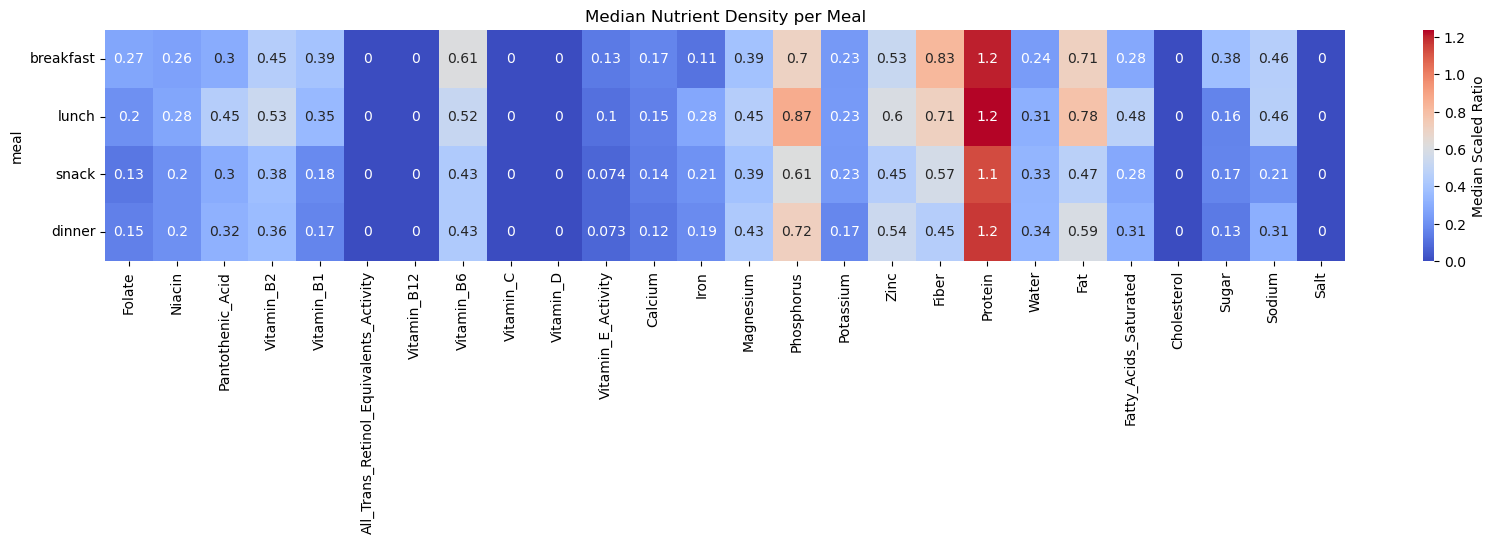

In [45]:
med = df_food_clean_scaled.groupby('meal')[nutrient_cols].median().loc[meal_types]

plt.figure(figsize=(20, 3))
ax = sns.heatmap(
    med,
    cmap='coolwarm',
    annot=True,
    cbar_kws={'label': 'Median Scaled Ratio'}
)
ax.set_yticklabels(meal_types, rotation=0)
ax.set_xticklabels(
    [n.replace('_eaten_ratio_scaled','').title() for n in nutrient_cols],
    rotation=90
)
plt.title('Median Nutrient Density per Meal')
plt.tight_layout()
filename = f"{save_path_distribution}/median_density_heatmap.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Sophie\AppData\Local\Temp\ipykernel_11136\280955395.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


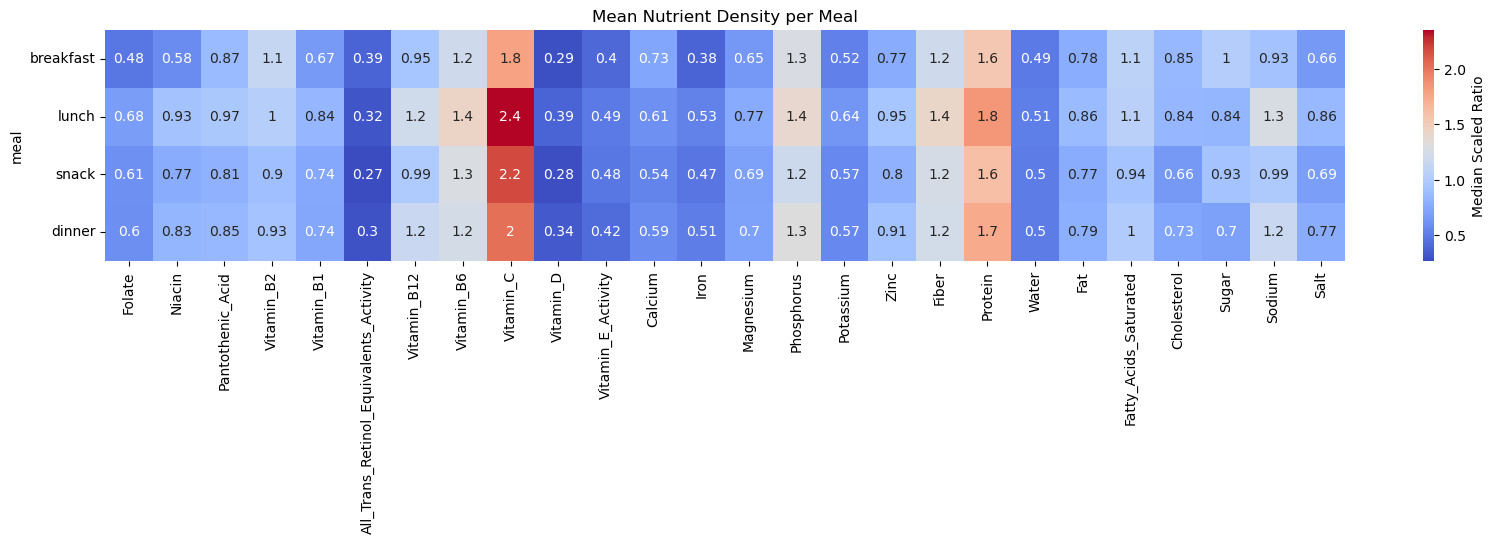

In [46]:
med = df_food_clean_scaled.groupby('meal')[nutrient_cols].mean().loc[meal_types]

plt.figure(figsize=(20, 3))
ax = sns.heatmap(
    med,
    cmap='coolwarm',
    annot=True,
    cbar_kws={'label': 'Median Scaled Ratio'}
)
ax.set_yticklabels(meal_types, rotation=0)
ax.set_xticklabels(
    [n.replace('_eaten_ratio_scaled','').title() for n in nutrient_cols],
    rotation=90
)
plt.title('Mean Nutrient Density per Meal')
plt.tight_layout()
filename = f"{save_path_distribution}/mean_density_heatmap.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

- Vitamin D and RAe are the lowest micronutrient across every meal, may need a specific focus (e.g. fortified foods or supplements)
- The high density of vitamin C could come from frequent low-calorie vitamin C rich item. As printed after, bell pepper seems to appear in every meal, being the top contributor to vitamin C

In [47]:
for meal in ['breakfast','lunch','snack','dinner']:
    subset = df_food_clean[df_food_clean['meal']==meal]
    
    # 1️⃣ group by food, summing the vitamin C and kcal eaten
    grouped = (subset
               .groupby('combined_name')
               .agg({
                   'vitamin_c_eaten': 'mean',
                   'energy_kcal_eaten': 'mean'
               }))
    
    # 2️⃣ sort descending and pick top 5
    top5 = grouped.sort_values('vitamin_c_eaten', ascending=False).head(5)
    
    print(f"\nTop 5 vitamin C foods in {meal}:")
    print(top5)


Top 5 vitamin C foods in breakfast:
                                                    vitamin_c_eaten  \
combined_name                                                         
Bell pepper, red, yellow, raw                              0.194700   
Bell pepper, red, stewed, without addition of f...         0.192400   
Betty Bossi mango                                          0.132000   
Parsley                                                    0.109200   
Broccoli                                                   0.108905   

                                                    energy_kcal_eaten  
combined_name                                                          
Bell pepper, red, yellow, raw                                   37.76  
Bell pepper, red, stewed, without addition of f...              43.68  
Betty Bossi mango                                              186.00  
Parsley                                                         33.60  
Broccoli                         

1. **Median heatmap** = typical meal  
Interpretation : In most micronutrient (e.g. RAE, vitamin b12, vitamin d) their median value is zero, that means that most meals don't deliver any of those nutrients in more than half of the data
2. **Mean heatmap** = average meal  
Interpretation : Arithmetic average, get pulled up by low-calorie "powerfull" item (e.g. bell pepper)